# Predictive Modeling of House Prices: A Machine Learning Approach

# Load libraries & data

## Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype

import scipy.stats as stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, precision_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [11]:
# test dataset
df_train = pd.read_csv("train.csv")
df_train = df_train.drop('Id', axis = 1) # Drop ID from dataset

# print data info
print("dataset shape:", df_train.shape)
print("\nInfo:")
print(df_train.info())

print("\nDescribe:")
print(df_train.describe())


dataset shape: (1460, 80)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460

# Exploratory Data Analysis

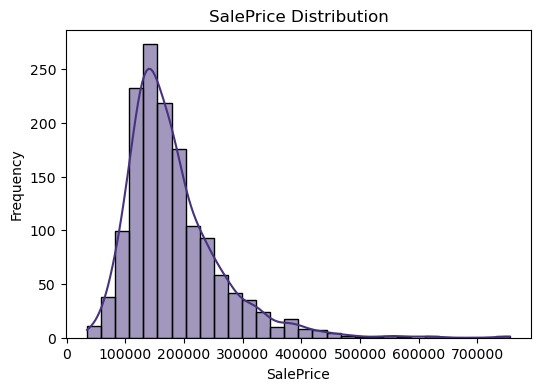

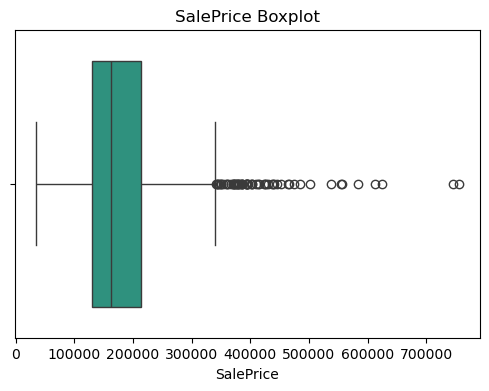

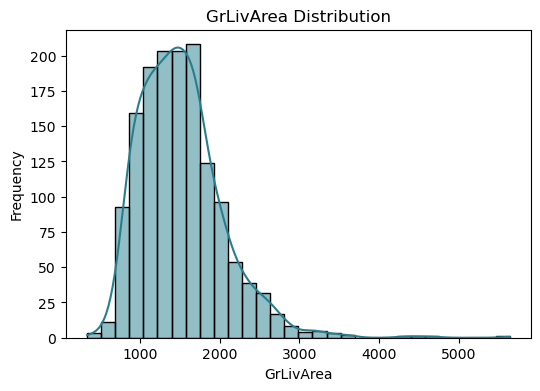

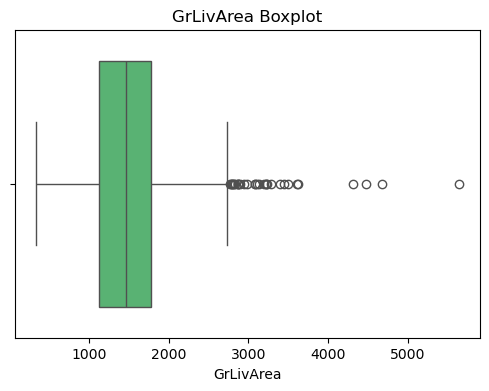

In [3]:
sns.set_palette("viridis")

# Histogram 'SalePrice'
plt.figure(figsize=(6, 4))
sns.histplot(df_train['SalePrice'], kde=True, bins=30, color=sns.color_palette("viridis")[0])
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Boxplot 'SalePrice'
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_train['SalePrice'], color=sns.color_palette("viridis")[3])
plt.title('SalePrice Boxplot')
plt.xlabel('SalePrice')
plt.show()

# Histogram 'GrLivArea'
plt.figure(figsize=(6, 4))
sns.histplot(df_train['GrLivArea'], kde=True, bins=30, color=sns.color_palette("viridis")[2])
plt.title('GrLivArea Distribution')
plt.xlabel('GrLivArea')
plt.ylabel('Frequency')
plt.show()

# Boxplot 'GrLivArea'
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_train['GrLivArea'], color=sns.color_palette("viridis")[4])
plt.title('GrLivArea Boxplot')
plt.xlabel('GrLivArea')
plt.show()


In [4]:
# Missing values
missing = df_train.isnull().sum()
missing_percent = (missing / df_train.shape[0]) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print("Missing values per column:")
print(missing_df.sort_values(by='Missing %', ascending=False))

# Correlation matrix
df_numeric = df_train.select_dtypes(include = ['float64', 'int64'])
corr_matrix = df_numeric.corr()

saleprice_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
print("\nSalePrice correlations:")
print(saleprice_corr)

# outliers
def outlier_analysis(series, variable_name):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    total = series.shape[0]
    percent_outliers = 100 * outliers.shape[0] / total
    print(f"\nOutliers for {variable_name}:")
    print(f"  Total observations: {total}")
    print(f"  Number of outliers: {outliers.shape[0]}")
    print(f"  Outliers %: {percent_outliers:.2f}%")
    print(f"  Min value outliers: {outliers.min()}")
    print(f"  Max value outliers: {outliers.max()}")

# SalePrice outliers 
outlier_analysis(df_train['SalePrice'], 'SalePrice')

Missing values per column:
             Missing Count  Missing %
PoolQC                1453  99.520548
MiscFeature           1406  96.301370
Alley                 1369  93.767123
Fence                 1179  80.753425
MasVnrType             872  59.726027
...                    ...        ...
Heating                  0   0.000000
HeatingQC                0   0.000000
MSZoning                 0   0.000000
1stFlrSF                 0   0.000000
SalePrice                0   0.000000

[80 rows x 2 columns]

SalePrice correlations:
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
O

### Numerical Feature Analysis

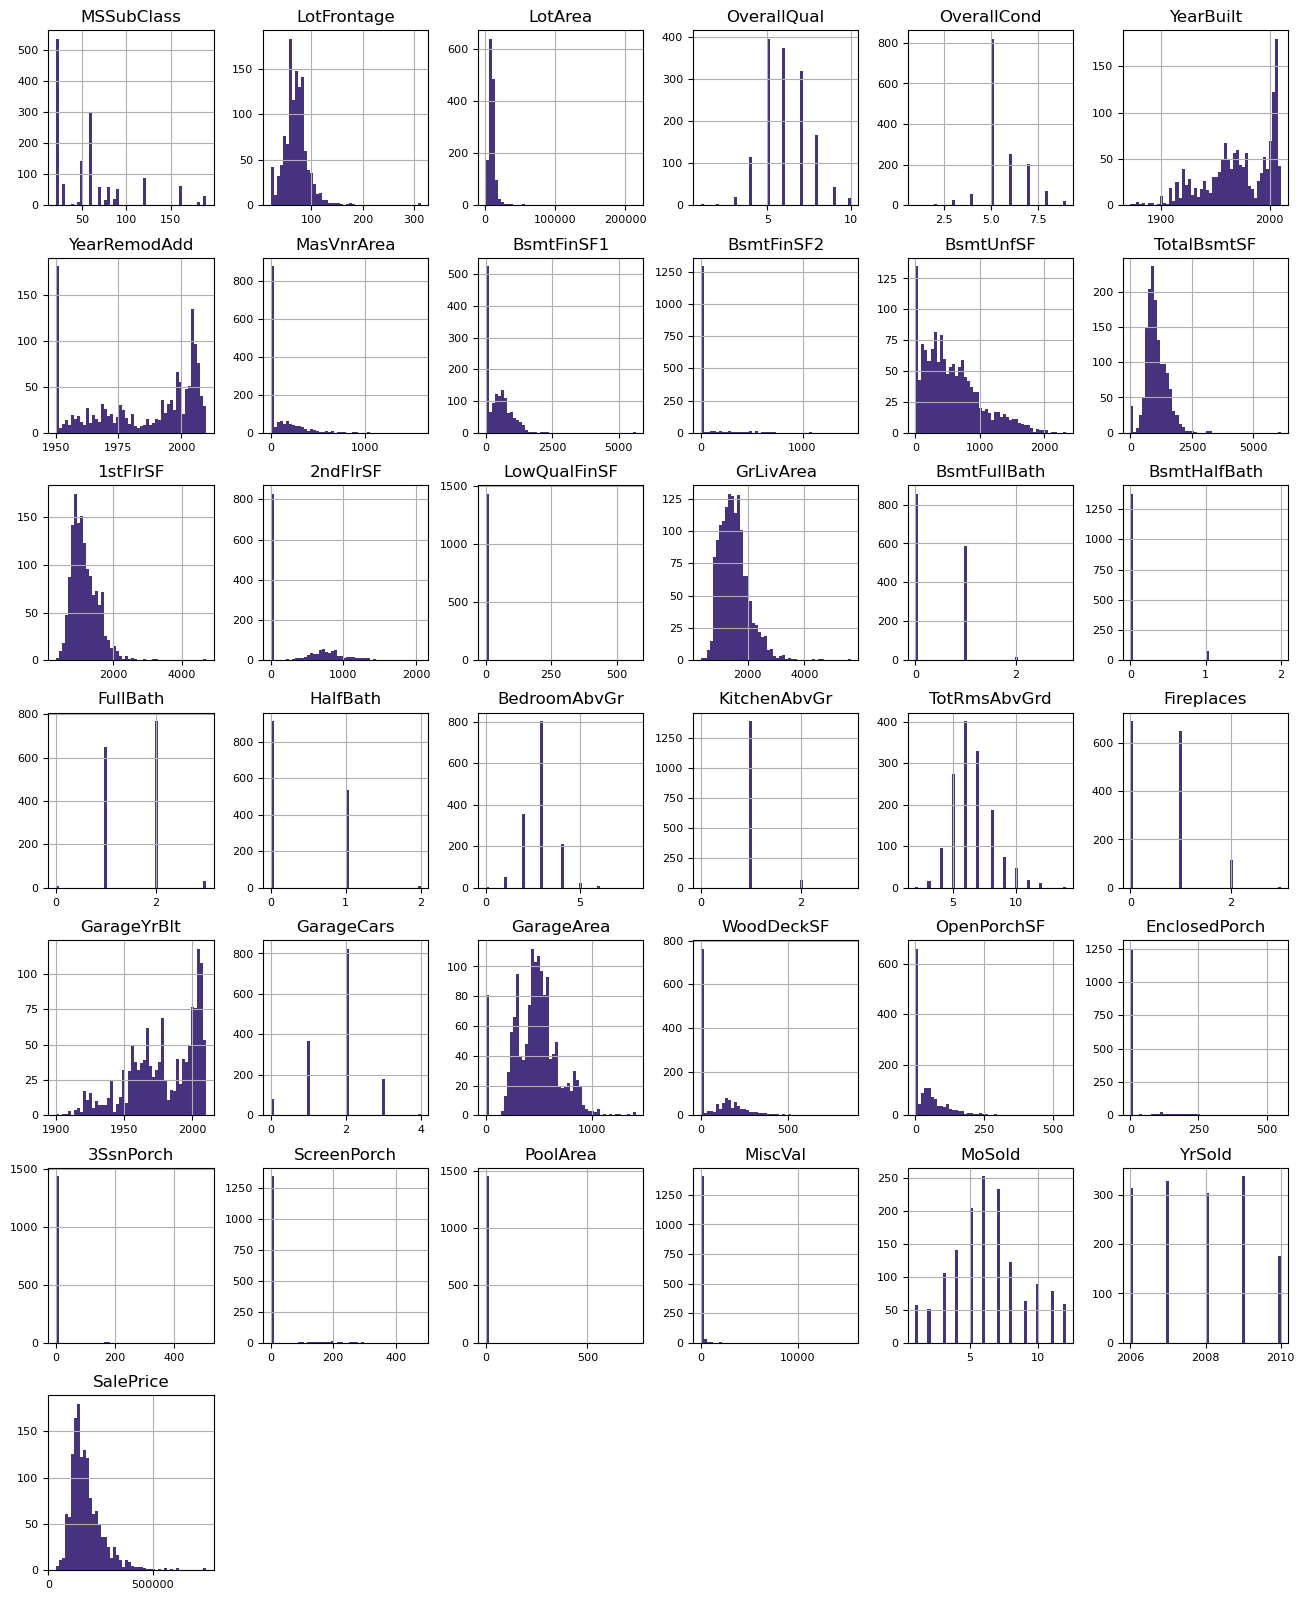

In [6]:
'''
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
'''

### Categorical Feature Analysis

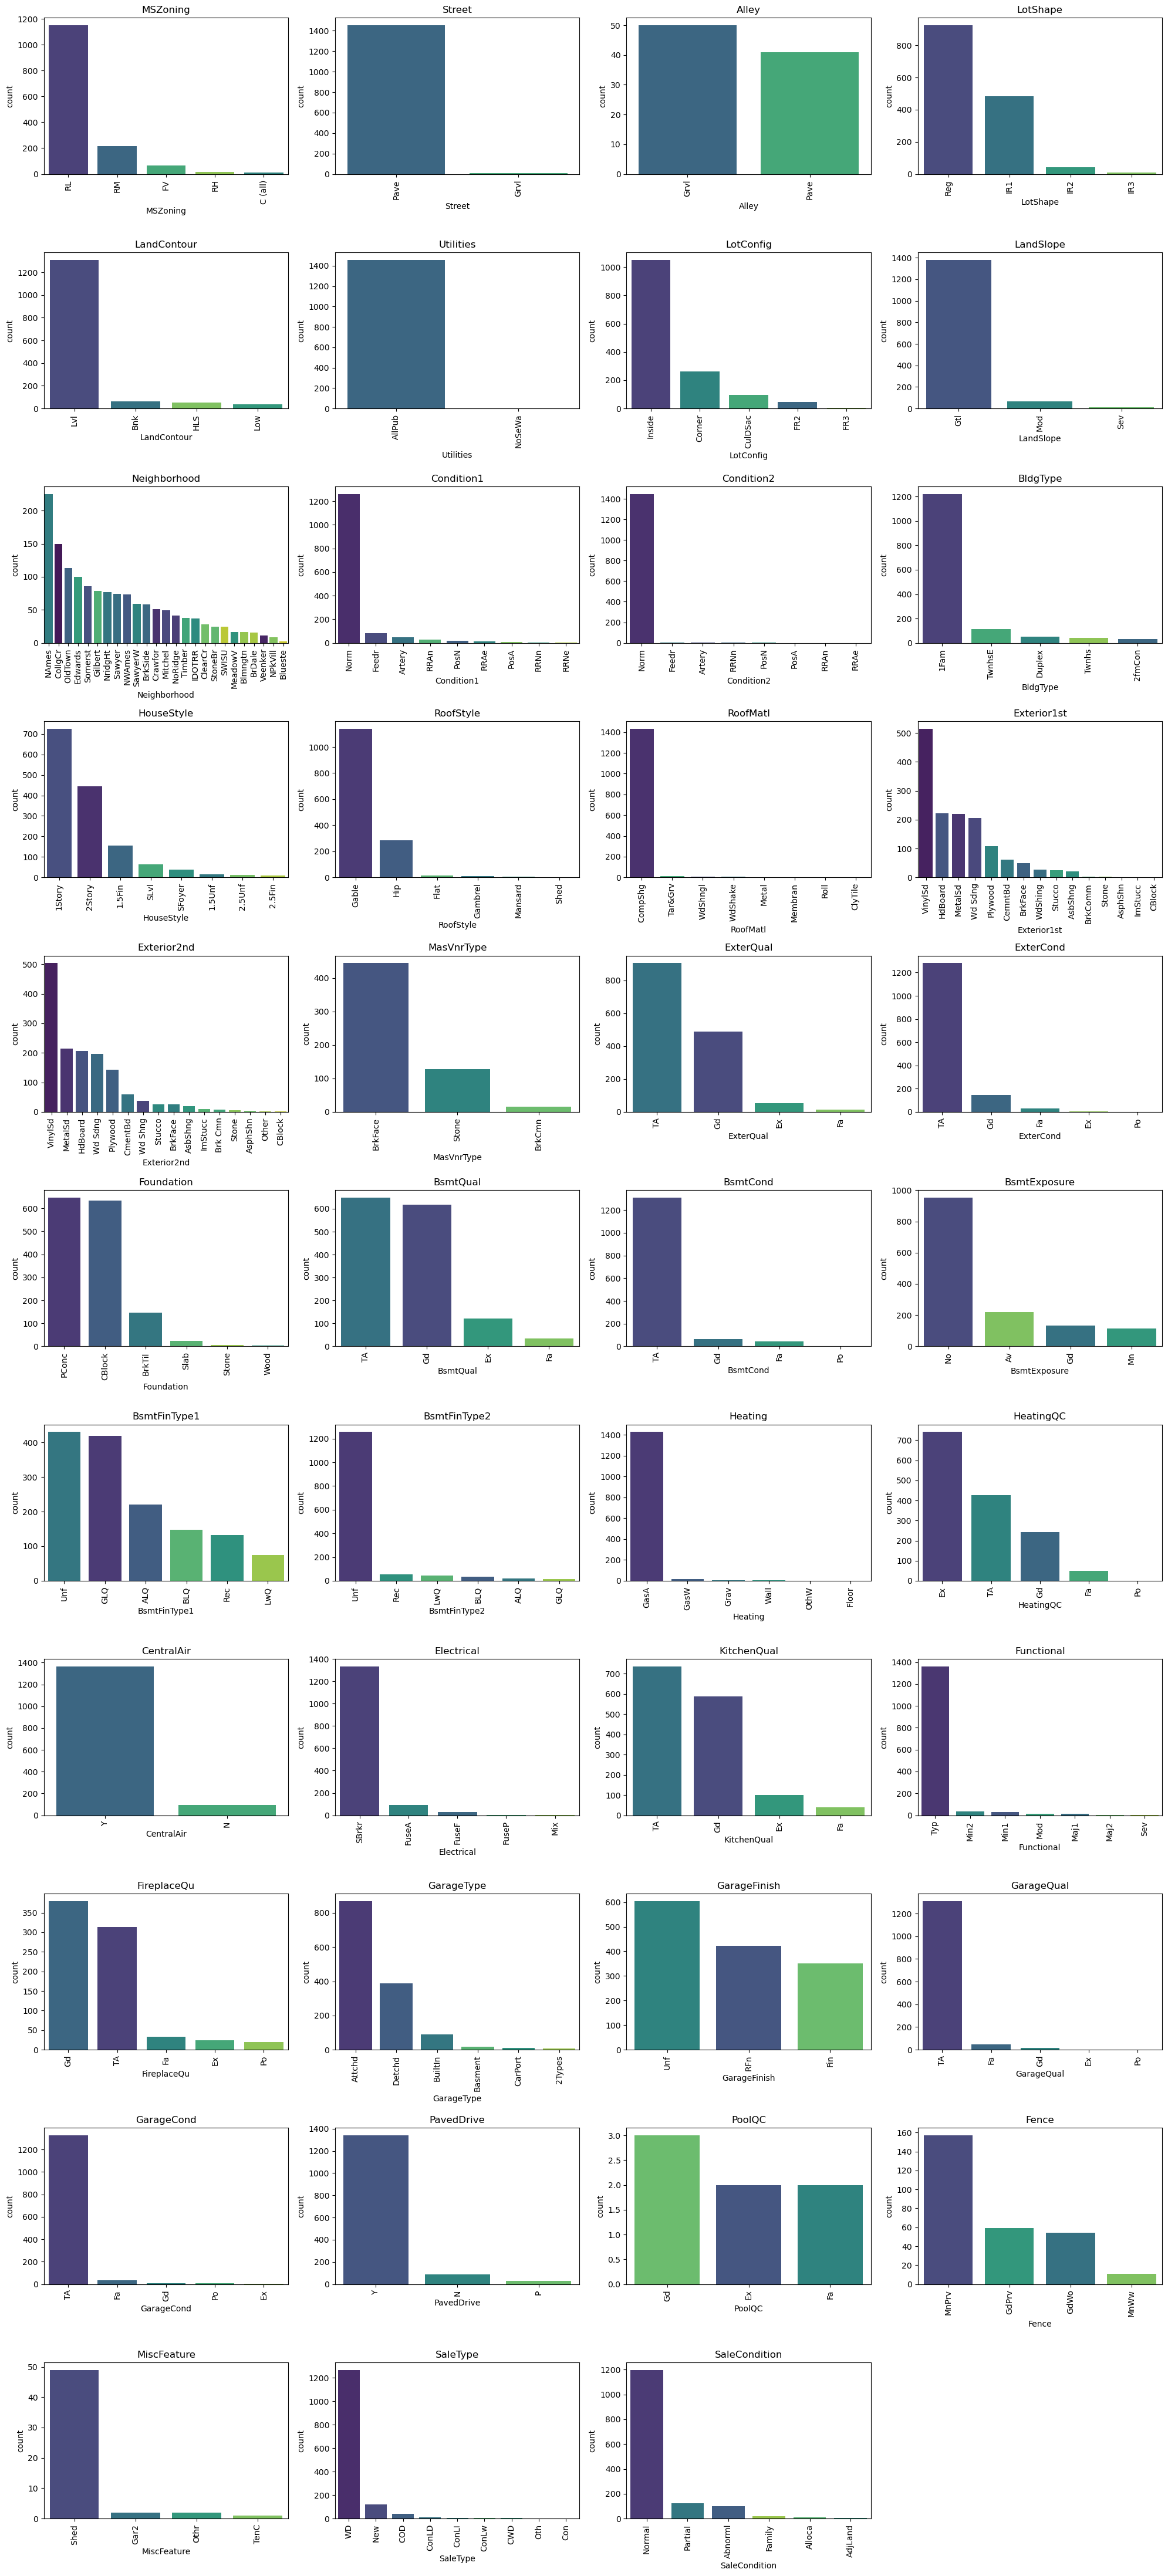

In [7]:
'''
# Select categorical features
categorical_features = df_train.select_dtypes(include=['object']).columns

# Determine grid size
num_features = len(categorical_features)
num_cols = 4  # Adjust this for better layout
num_rows = math.ceil(num_features / num_cols)

# Create subplots
plt.figure(figsize=(num_cols * 5, num_rows * 4))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(x=df_train[col], order=df_train[col].value_counts().index, hue=df_train[col], 
                  palette="viridis", legend=False)  # Set `hue=x` and disable legend
    plt.xticks(rotation=90)
    plt.title(col)

plt.tight_layout()
plt.show()
'''

## Correlation with SalePrice

In [5]:
# Correlation matrix
df_numeric = df_train.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()

saleprice_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
print("\nSalePrice correlations:")
print(saleprice_corr)


SalePrice correlations:
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePri

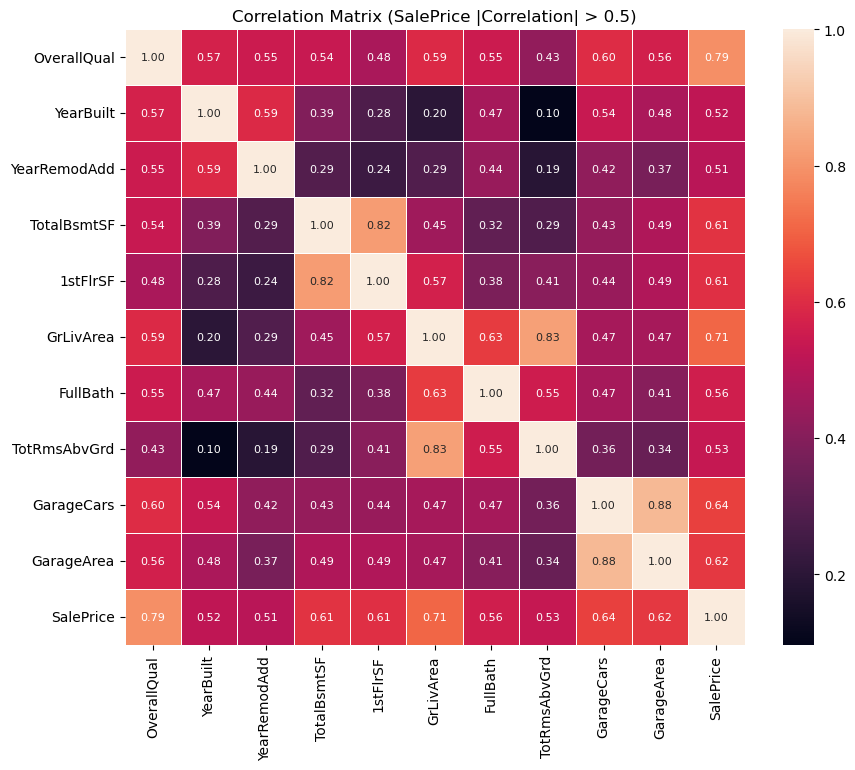

In [6]:
df_numeric = df_train.select_dtypes(include=[np.number])

corr_matrix = df_numeric.corr()

corr_threshold = 0.5
strong_corr_vars = corr_matrix["SalePrice"][abs(corr_matrix["SalePrice"]) > corr_threshold].index

filtered_corr_matrix = corr_matrix.loc[strong_corr_vars, strong_corr_vars]

plt.figure(figsize=(10, 8))

sns.heatmap(
    filtered_corr_matrix, 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5, 
    annot_kws={"size": 8}  
)

plt.title("Correlation Matrix (SalePrice |Correlation| > 0.5)")
plt.show()


## Check Multicollinearity with VIF

In [7]:
# numeric values
df_numeric = df_train.select_dtypes(include=[np.number]).drop(columns=["SalePrice"], errors="ignore")

# Missing values

## delete columns with more than 90% missing values
threshold = 0.9  
missing_percent = df_numeric.isnull().mean()
df_cleaned = df_numeric.loc[:, missing_percent < threshold]

# replace na with median values
df_cleaned = df_cleaned.fillna(df_cleaned.median())

# VIF
vif_data_cleaned = pd.DataFrame()
vif_data_cleaned["Variable"] = df_cleaned.columns
vif_data_cleaned["VIF"] = [variance_inflation_factor(df_cleaned.values, i) for i in range(len(df_cleaned.columns))]

# results
vif_data_cleaned["VIF"] = round(vif_data_cleaned["VIF"])
vif_data_cleaned[vif_data_cleaned["VIF"] <= 5]

C:\Users\amali\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,MSSubClass,5.0
2,LotArea,3.0
7,MasVnrArea,2.0
16,BsmtFullBath,4.0
17,BsmtHalfBath,1.0
19,HalfBath,3.0
23,Fireplaces,3.0
27,WoodDeckSF,2.0
28,OpenPorchSF,2.0
29,EnclosedPorch,1.0


## Correlation Matrix

Only including variables with high correlation

In [7]:
# correlation matrix
correlation_matrix = df_cleaned.corr().abs()

# variables with high correlation
high_correlation_vars = (correlation_matrix > 0.5).sum() > 1
selected_vars = correlation_matrix.loc[high_correlation_vars, high_correlation_vars]
num_selected_vars = selected_vars.shape[0]

selected_var_names = selected_vars.columns.tolist()
num_selected_vars, selected_var_names


(16,
 ['OverallQual',
  'YearBuilt',
  'YearRemodAdd',
  'BsmtFinSF1',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'GrLivArea',
  'BsmtFullBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'TotRmsAbvGrd',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea'])

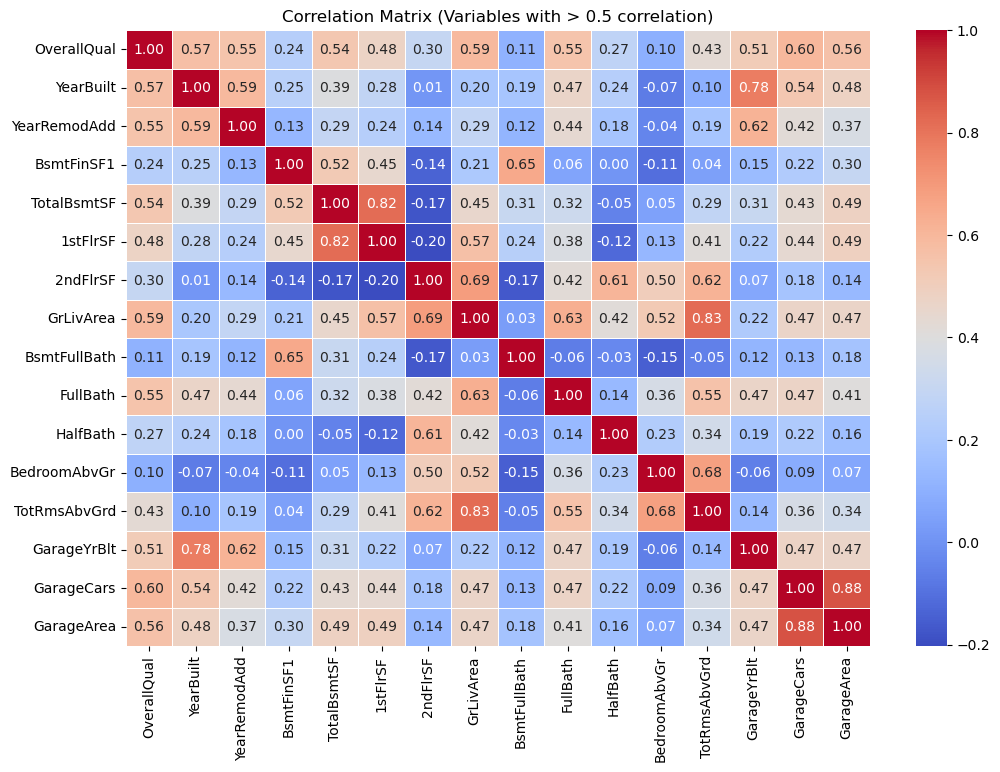

In [8]:
# new data fram
df_corr_selected = df_cleaned[selected_var_names]

# correlation matrix
corr_matrix_selected = df_corr_selected.corr()

# plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_selected, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Variables with > 0.5 correlation)")
plt.show()


### Delete variables with high correlation

In [9]:
#df_reduced = df_corr_selected.copy()
df_reduced = df_train.select_dtypes(include=[np.number]).drop(columns=["SalePrice"], errors="ignore")

threshold = 0.8

# new correlation matrix
corr_matrix_upper = corr_matrix_selected.where(np.triu(np.ones(corr_matrix_selected.shape), k=1).astype(bool))

# high correlation variables
to_drop = [column for column in corr_matrix_upper.columns if any(corr_matrix_upper[column] > threshold)]

# delete variables
df_reduced.drop(columns=to_drop, inplace=True)

# Mostrar las variables eliminadas y las variables restantes
print(f"Variables deleted because high correlation (> {threshold}): {to_drop}")
print(f"Variables selected after elimination: {df_reduced.columns.tolist()}")


Variables deleted because high correlation (> 0.8): ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']
Variables selected after elimination: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


## Outlier plots

In [11]:
from scipy.stats import zscore

# Calculate z-scores for numerical features
numerical_features = df_cleaned.select_dtypes(include=['float64', 'int64'])
z_scores = numerical_features.apply(zscore)

# Find features with high z-scores (e.g., greater than 3 or less than -3)
outliers = (z_scores > 3) | (z_scores < -3)

# Count the number of outliers in each feature
outliers_count = outliers.sum()

# Sort the features by the number of outliers in descending order
sorted_outliers_count = outliers_count.sort_values(ascending=False)

# Print the number of outliers per feature, sorted from highest to lowest
print("Number of Outliers per Feature (Sorted):")
print(sorted_outliers_count)

Number of Outliers per Feature (Sorted):
BsmtHalfBath     82
KitchenAbvGr     68
ScreenPorch      55
EnclosedPorch    51
BsmtFinSF2       50
MasVnrArea       32
MSSubClass       30
OverallCond      28
OpenPorchSF      27
3SsnPorch        23
WoodDeckSF       22
LowQualFinSF     20
BsmtFullBath     16
LotFrontage      16
GrLivArea        16
BedroomAbvGr     14
LotArea          13
TotRmsAbvGrd     12
HalfBath         12
1stFlrSF         12
BsmtUnfSF        11
TotalBsmtSF      10
MiscVal           8
PoolArea          7
GarageArea        7
BsmtFinSF1        6
YearBuilt         6
Fireplaces        5
2ndFlrSF          4
OverallQual       2
GarageYrBlt       2
MoSold            0
FullBath          0
GarageCars        0
YearRemodAdd      0
YrSold            0
dtype: int64


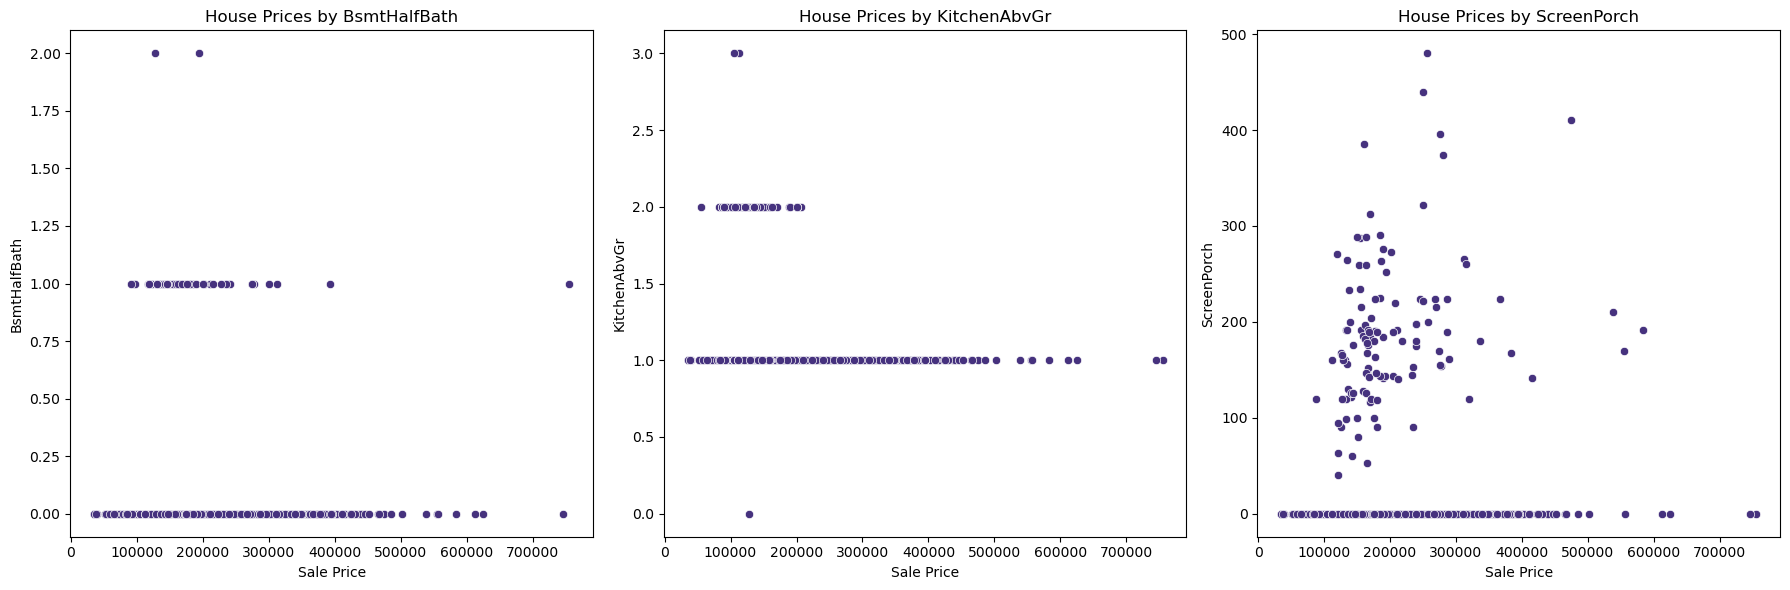

In [12]:
df_outlier = df_train.copy()

# Set figure size and layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Define a Viridis color palette
palette = sns.color_palette("viridis")

# Plot 1: Neighborhood vs SalePrice
sns.scatterplot(ax=axes[0], y='BsmtHalfBath', x='SalePrice', data=df_outlier, palette=palette)
axes[0].set_title('House Prices by BsmtHalfBath')
axes[0].set_ylabel('BsmtHalfBath')
axes[0].set_xlabel('Sale Price')

# Plot 2: MSZoning vs SalePrice
sns.scatterplot(ax=axes[1], y='KitchenAbvGr', x='SalePrice', data=df_outlier, palette=palette)
axes[1].set_title('House Prices by KitchenAbvGr')
axes[1].set_ylabel('KitchenAbvGr')
axes[1].set_xlabel('Sale Price')

# Plot 3: SaleCondition vs SalePrice
sns.scatterplot(ax=axes[2], y='ScreenPorch', x='SalePrice', data=df_outlier, palette=palette)
axes[2].set_title('House Prices by ScreenPorch')
axes[2].set_ylabel('ScreenPorch')
axes[2].set_xlabel('Sale Price')

# Adjust layout
plt.tight_layout()
plt.show()

## Categorical variables

In [13]:
df_plot = pd.read_csv("train.csv", parse_dates = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'])
df_plot['YearBuilt'] = df_plot['YearBuilt'].dt.year
df_plot['YearRemodAdd'] = df_plot['YearRemodAdd'].dt.year
df_plot['GarageYrBlt'] = df_plot['GarageYrBlt'].dt.year
df_plot['YrSold'] = df_plot['YrSold'].dt.year
df_plot.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


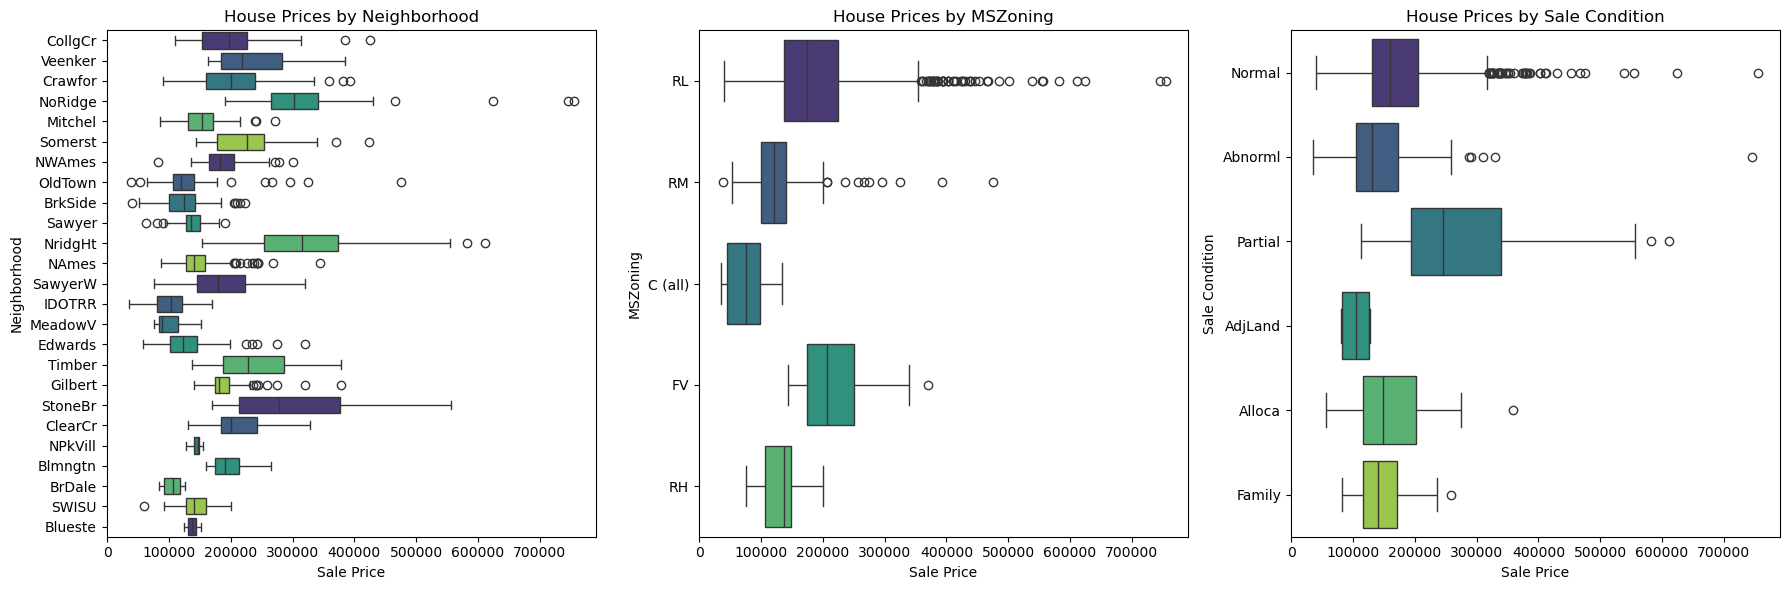

In [14]:
#df_plot['OverallCond'] = df_plot['OverallCond'].astype('category')

# Set figure size and layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Define a Viridis color palette
palette = sns.color_palette("viridis")

# Plot 1: Neighborhood vs SalePrice
sns.boxplot(ax=axes[0], y='Neighborhood', x='SalePrice', data=df_plot, palette=palette)
axes[0].set_title('House Prices by Neighborhood')
axes[0].set_ylabel('Neighborhood')
axes[0].set_xlabel('Sale Price')

# Plot 2: MSZoning vs SalePrice
sns.boxplot(ax=axes[1], y='MSZoning', x='SalePrice', data=df_plot, palette=palette)
axes[1].set_title('House Prices by MSZoning')
axes[1].set_ylabel('MSZoning')
axes[1].set_xlabel('Sale Price')

# Plot 3: SaleCondition vs SalePrice
sns.boxplot(ax=axes[2], y='SaleCondition', x='SalePrice', data=df_plot, palette=palette)
axes[2].set_title('House Prices by Sale Condition')
axes[2].set_ylabel('Sale Condition')
axes[2].set_xlabel('Sale Price')

# Adjust layout
plt.tight_layout()
plt.show()

## Check linear/non-linear relationships

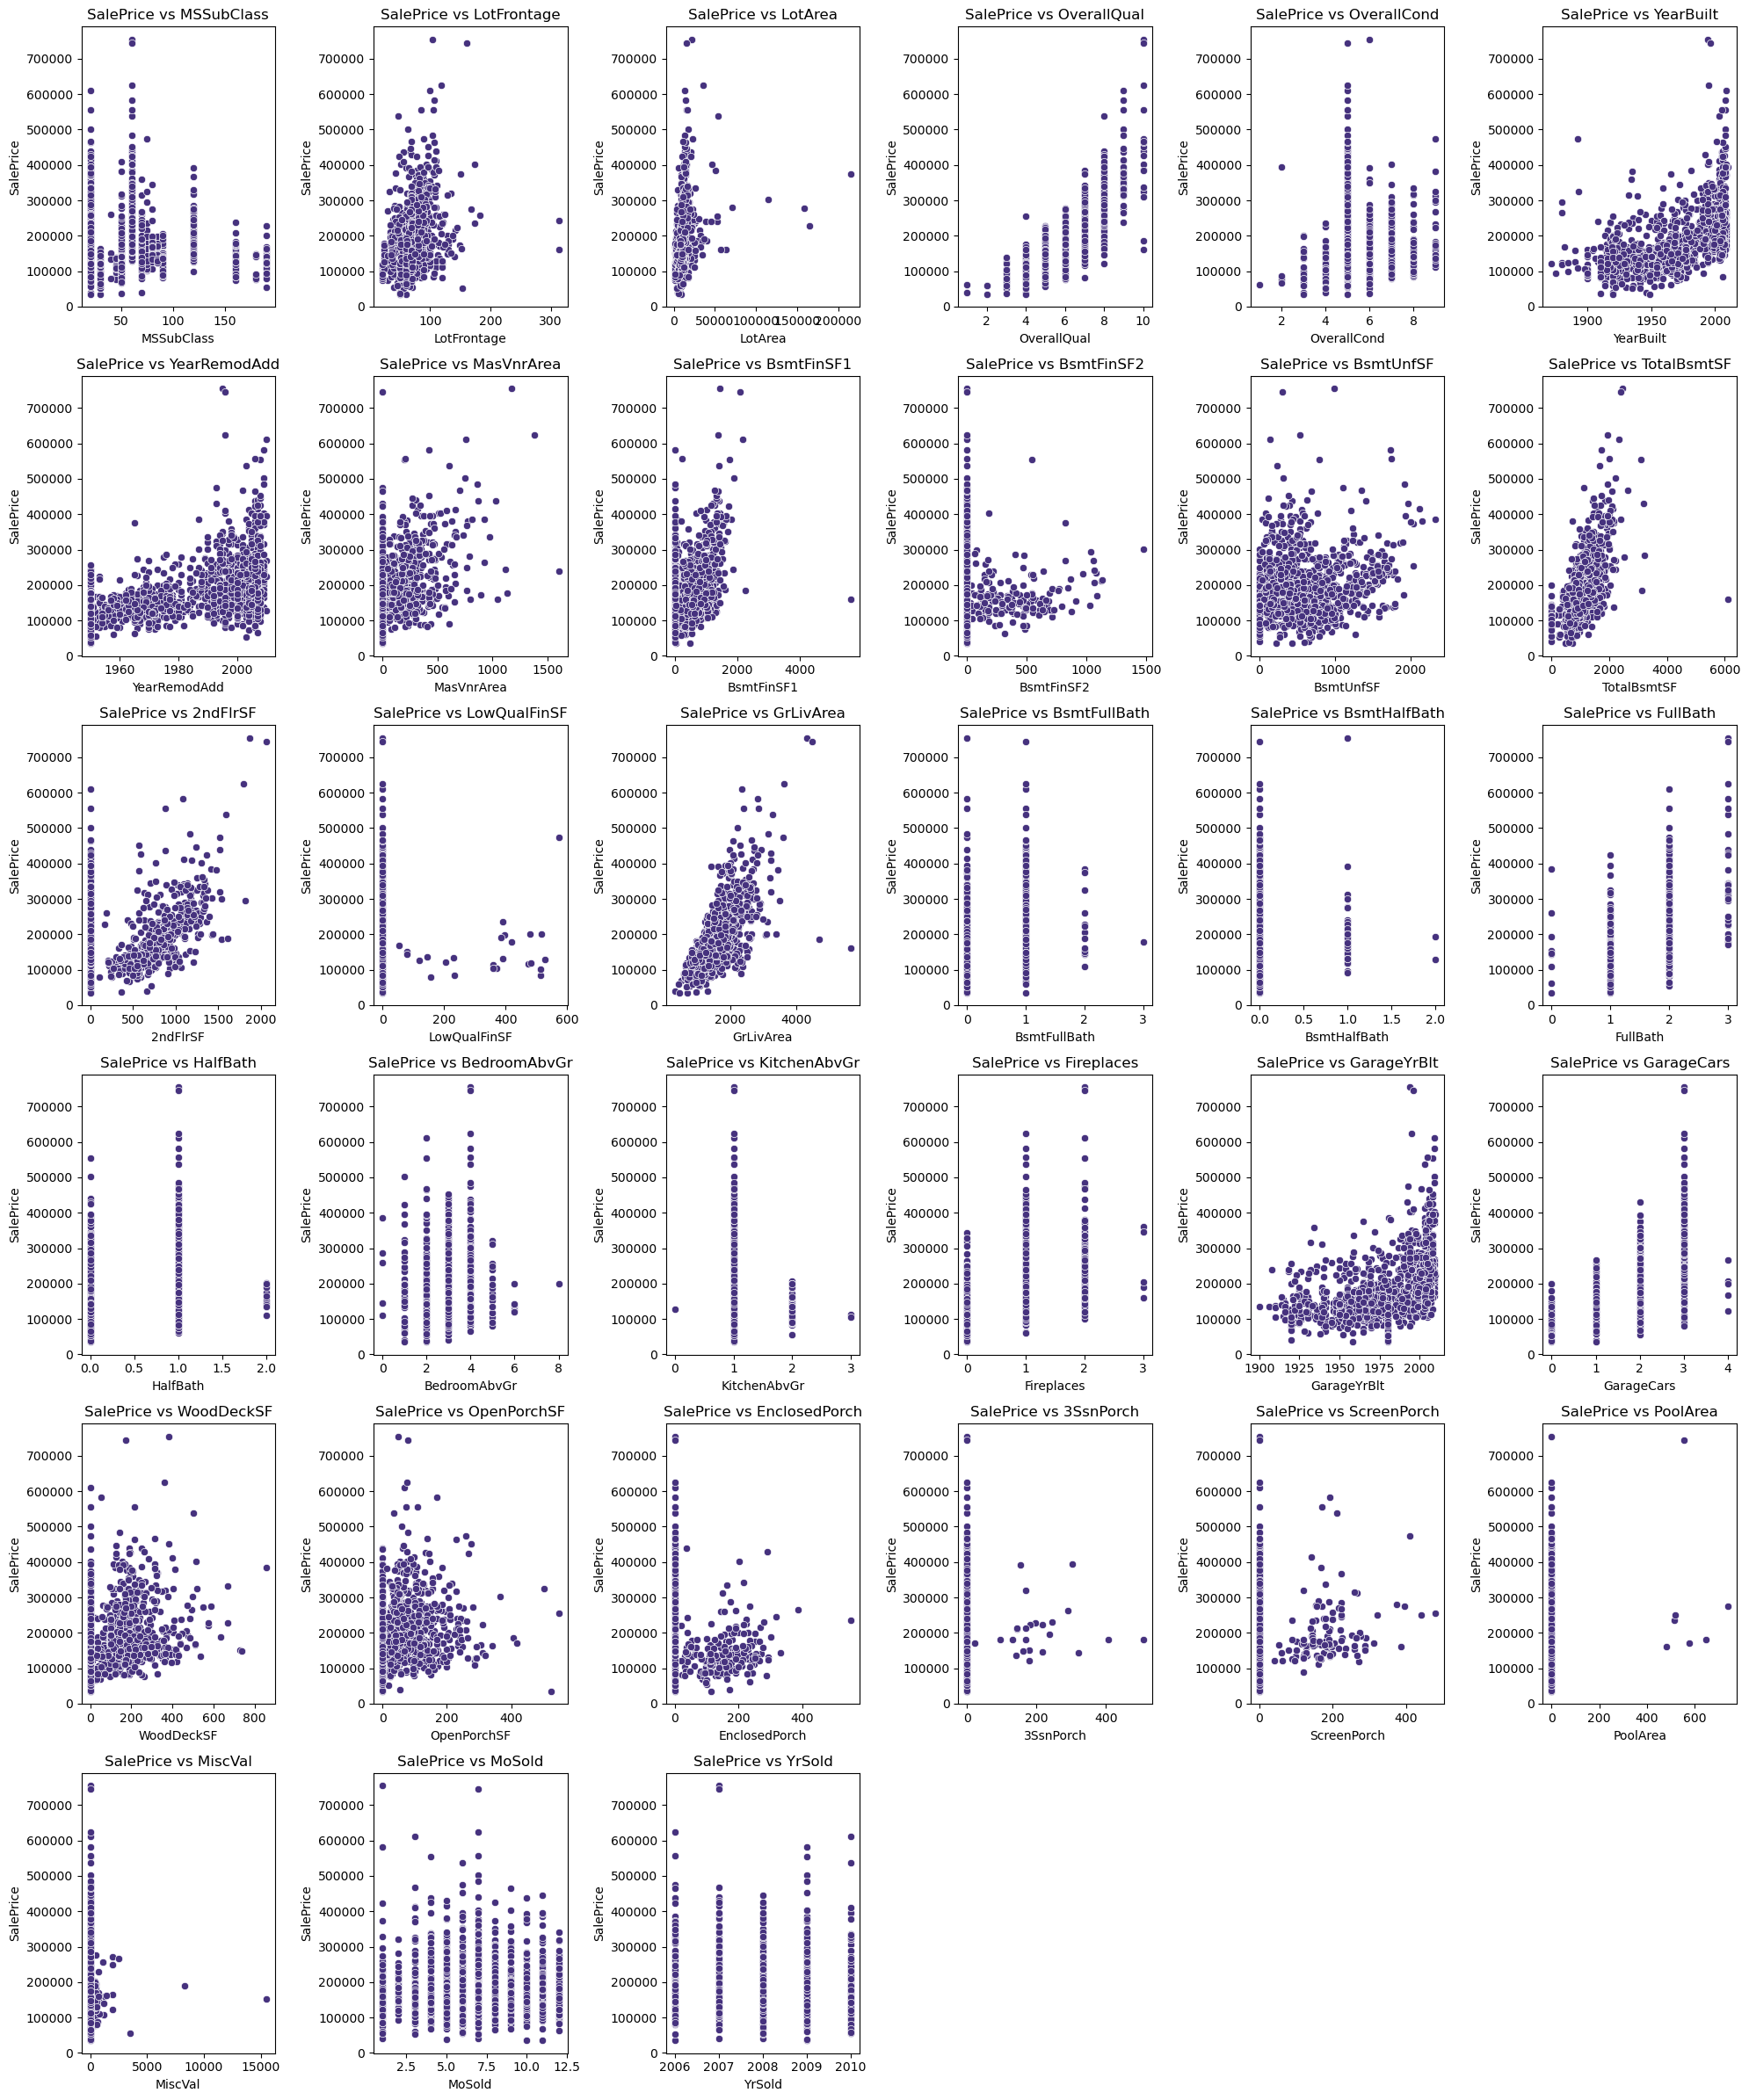

In [17]:
'''
# Add SalePrice to the reduced dataset
df_plot = df_cleaned.copy()
df_plot["SalePrice"] = df_train["SalePrice"]

# variables to plot
key_variables = df_reduced.columns.tolist()

# size 6x6
cols = 6
rows = math.ceil(len(key_variables) / cols)  

# plot
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten() 

# scatter plots 
for i, var in enumerate(key_variables):
    sns.scatterplot(x=df_plot[var], y=df_plot["SalePrice"], ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("SalePrice")
    axes[i].set_title(f"SalePrice vs {var}")

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
'''

In [ ]:
# numeric values
df_numeric = df_train.select_dtypes(include=[np.number])

## delete columns with more than 90% missing values
threshold = 0.9  
missing_percent = df_numeric.isnull().mean()
df_cleaned = df_numeric.loc[:, missing_percent < threshold]

# replace na with median values
df_cleaned = df_cleaned.fillna(df_cleaned.median())

df_plot = df_cleaned.copy()
#df_plot["SalePrice"] = df_train["SalePrice"]

# key variables
key_variables = df_reduced.columns.tolist()

# 6x6
cols = 6
rows = math.ceil(len(key_variables) / cols)

# plot
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten()

# polinomial 
for i, var in enumerate(key_variables):
    sns.scatterplot(x=df_plot[var], y=df_plot["SalePrice"], ax=axes[i], alpha=0.5)
    sns.regplot(x=df_plot[var], y=df_plot["SalePrice"], ax=axes[i], scatter=False, color='red', order=2)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("SalePrice")
    axes[i].set_title(f"SalePrice vs {var} (Non-Linear Fit)")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Transformations

In [12]:
# numeric values
df_numeric = df_train.select_dtypes(include=[np.number])

# Missing values

## delete columns with more than 90% missing values
threshold = 0.9  
missing_percent = df_numeric.isnull().mean()
df_cleaned = df_numeric.loc[:, missing_percent < threshold]

# replace na with median values
df_cleaned = df_cleaned.fillna(df_cleaned.median())

# logarithmic transformation
log_vars = ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea", "2ndFlrSF"]
df_transformed = df_cleaned.copy()
df_transformed[log_vars] = np.log1p(df_transformed[log_vars])

# categorical variables
categorical_vars = ["FullBath", "HalfBath", "BedroomAbvGr", "BsmtFullBath"]
df_transformed[categorical_vars] = df_transformed[categorical_vars].astype(str)  

print(df_transformed.head())


   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  WoodDeckSF  \
0          2003       196.0         706           0  ...           0   
1          1976         0.0         978           0  ...         298   
2          2002       162.0         486           0  ...           0   
3          1970         0.0         216           0  ...           0   
4          2000       350.0         655           0  ...         192   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea MiscVal  \
0           61              0      

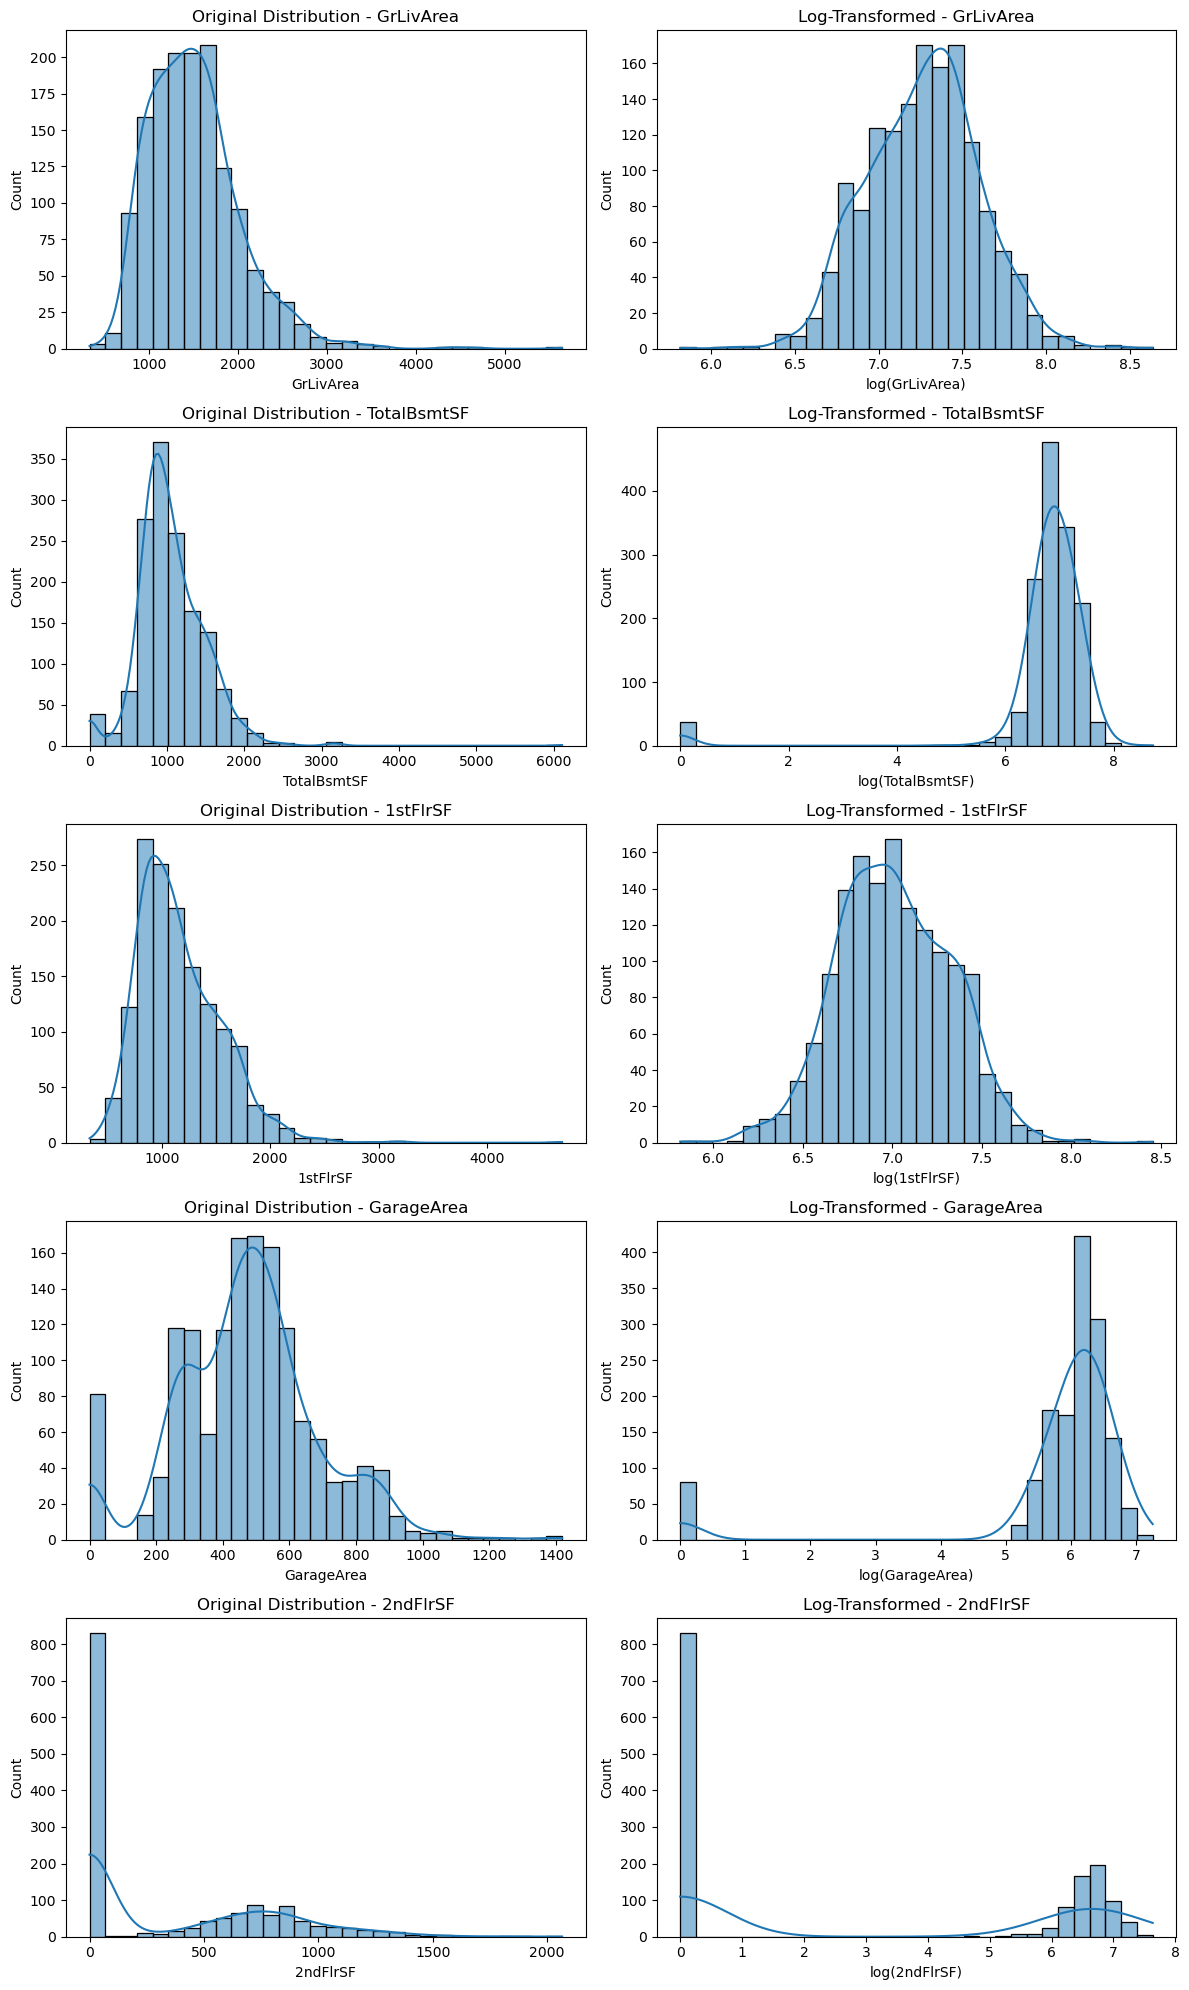

In [13]:
# trnasformed variables
log_vars = ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea", "2ndFlrSF"]

#plot
fig, axes = plt.subplots(len(log_vars), 2, figsize=(12, len(log_vars) * 4))

for i, var in enumerate(log_vars):
    # histogram before transformation
    sns.histplot(df_cleaned[var], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Original Distribution - {var}")
    axes[i, 0].set_xlabel(var)

    # histogram after transformation
    sns.histplot(df_transformed[var], bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Log-Transformed - {var}")
    axes[i, 1].set_xlabel(f"log({var})")

plt.tight_layout()
plt.show()


## Data Preprocessing pipeline for Predictive Modelling

### Define log-transformed SalePrice variables

In [3]:
# Load dataset
df_train = pd.read_csv("train.csv")

df_train = df_train.drop('Id', axis = 1) # Drop ID column
df_train['log(SalePrice)'] = np.log1p(df_train["SalePrice"]) # Log transformation of target variable = 'SalePrice'
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      1460 non-null   int64  
 1   MSZoning        1460 non-null   object 
 2   LotFrontage     1201 non-null   float64
 3   LotArea         1460 non-null   int64  
 4   Street          1460 non-null   object 
 5   Alley           91 non-null     object 
 6   LotShape        1460 non-null   object 
 7   LandContour     1460 non-null   object 
 8   Utilities       1460 non-null   object 
 9   LotConfig       1460 non-null   object 
 10  LandSlope       1460 non-null   object 
 11  Neighborhood    1460 non-null   object 
 12  Condition1      1460 non-null   object 
 13  Condition2      1460 non-null   object 
 14  BldgType        1460 non-null   object 
 15  HouseStyle      1460 non-null   object 
 16  OverallQual     1460 non-null   int64  
 17  OverallCond     1460 non-null   i

### Handle missing values

In [4]:
## delete columns with more than 90% missing values
threshold = 0.9  
missing_percent = df_train.isnull().mean()
df_final = df_train.loc[:, missing_percent < threshold]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      1460 non-null   int64  
 1   MSZoning        1460 non-null   object 
 2   LotFrontage     1201 non-null   float64
 3   LotArea         1460 non-null   int64  
 4   Street          1460 non-null   object 
 5   LotShape        1460 non-null   object 
 6   LandContour     1460 non-null   object 
 7   Utilities       1460 non-null   object 
 8   LotConfig       1460 non-null   object 
 9   LandSlope       1460 non-null   object 
 10  Neighborhood    1460 non-null   object 
 11  Condition1      1460 non-null   object 
 12  Condition2      1460 non-null   object 
 13  BldgType        1460 non-null   object 
 14  HouseStyle      1460 non-null   object 
 15  OverallQual     1460 non-null   int64  
 16  OverallCond     1460 non-null   int64  
 17  YearBuilt       1460 non-null   i

### Handle multi-collinearity

In [5]:
# Handle multi-collinearity

# Define target variables
target_vars = ["SalePrice", "log(SalePrice)"]

# numeric values
df_numeric = df_final.select_dtypes(include=[np.number]).drop(columns=target_vars, errors="ignore")

# Compute absolute correlation matrix, excluding target variables
correlation_matrix = df_numeric.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicate comparisons
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find columns that have a correlation higher than threshold
threshold = 0.8
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop highly correlated columns, ensuring target variables are kept
df_final = df_final.drop(columns=to_drop, errors="ignore")

# Print dropped columns
print(f"Dropped {len(to_drop)} highly correlated columns: {to_drop}")


Dropped 4 highly correlated columns: ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']


In [ ]:
df_final.info()

### Imputation, Label Encoding for categorical variables, Standardizing numerical variables

In [6]:
# Separate features and target
X = df_final.drop(["SalePrice", "log(SalePrice)"], axis=1)
y = df_final["log(SalePrice)"]

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Categorical variables: Fill missing values
if categorical_features.any():
    imputer = SimpleImputer(strategy="most_frequent")
    df_final.loc[:, categorical_features] = imputer.fit_transform(df_final[categorical_features])

# Numerical variables: Median imputation
if numerical_features.any():
    imputer = SimpleImputer(strategy="median")
    df_final.loc[:, numerical_features] = imputer.fit_transform(df_final[numerical_features])

print(df_final.info())

# Label encoding for categorical variables
if categorical_features.any():
    label_encoder = LabelEncoder()
    for col in categorical_features:
        df_final.loc[:, col] = label_encoder.fit_transform(df_final[col])

# Standardizing numerical variables
if numerical_features.any():
    scaler = StandardScaler()
    df_final.loc[:, numerical_features] = scaler.fit_transform(df_final[numerical_features])

Categorical Features: Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')
Numerical Features: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', '

### Principal Component Analysis (PCA)

In [14]:
# numeric values
df_pca = df_transformed.select_dtypes(include=[np.number])

# standardize
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

# PCA
pca = PCA(n_components=0.95)  #95 variance
principal_components = pca.fit_transform(df_pca_scaled)

# varaince explained by PC
explained_variance = pca.explained_variance_ratio_
print("Variance explained by each principal component:", explained_variance)


Variance explained by each principal component: [0.19646056 0.07409521 0.06835175 0.05043089 0.04344111 0.03696686
 0.03594458 0.03381635 0.03319491 0.03244394 0.03171347 0.03050666
 0.02972094 0.02785686 0.02736191 0.02683351 0.02601303 0.02446591
 0.02322314 0.02208376 0.0215861  0.01992136 0.01883053 0.01493427]


In [15]:
# loadings
loadings = pd.DataFrame(pca.components_, columns=df_pca.columns)

loadings.index = [f'PC{i+1}' for i in range(len(loadings))]

top_pcs = loadings.iloc[:5]

top_vars_pc1 = top_pcs.loc["PC1"].abs().nlargest(5).index

filtered_loadings = top_pcs[top_vars_pc1]

#tools.display_dataframe_to_user(name="Top 5 PCs and Top 5 Variables in PC1", dataframe=filtered_loadings)
print(filtered_loadings)

     SalePrice  OverallQual  GarageCars  GrLivArea  1stFlrSF
PC1   0.351349     0.328123    0.302787   0.299999  0.262651
PC2   0.039149    -0.032363   -0.080861   0.338498  0.058371
PC3  -0.021401     0.100219    0.030374   0.129827 -0.280756
PC4  -0.049411     0.000754    0.012485  -0.013889  0.208001
PC5  -0.048745    -0.151605    0.045305   0.018849  0.209752


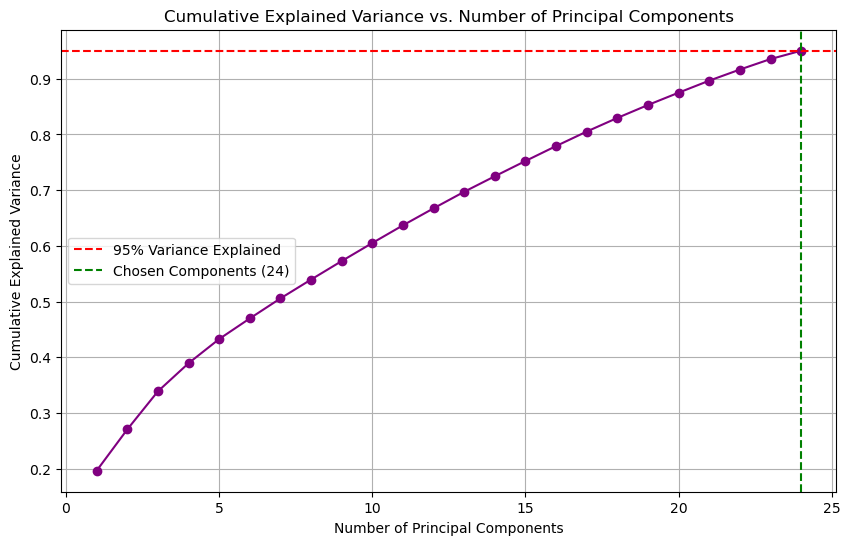

In [16]:
# cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='purple')

plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='--', label=f'Chosen Components ({np.argmax(cumulative_variance >= 0.95) + 1})')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.legend()
plt.grid()

plt.show()


### Factor Analysis

In [17]:
from sklearn.decomposition import FactorAnalysis
import numpy as np

n_factors = 10  # Choose based on variance explained
fa = FactorAnalysis(n_components=n_factors, random_state=42)

X = df_final.drop(["SalePrice","log(SalePrice)"], axis=1)
X_fa = fa.fit_transform(X)

# Compute the explained variance
# Explained variance can be approximated using the squared sum of loadings for each factor
explained_variance = np.sum(fa.components_**2, axis=1)

# Print the explained variance
print(f"Explained Variance by Factors:\n{explained_variance}")


Explained Variance by Factors:
[ 5.19468172  4.19854197  1.72372263  6.50113528 28.5366493   7.54476204
  5.70775264 16.22680275  1.39865068  1.10280556]


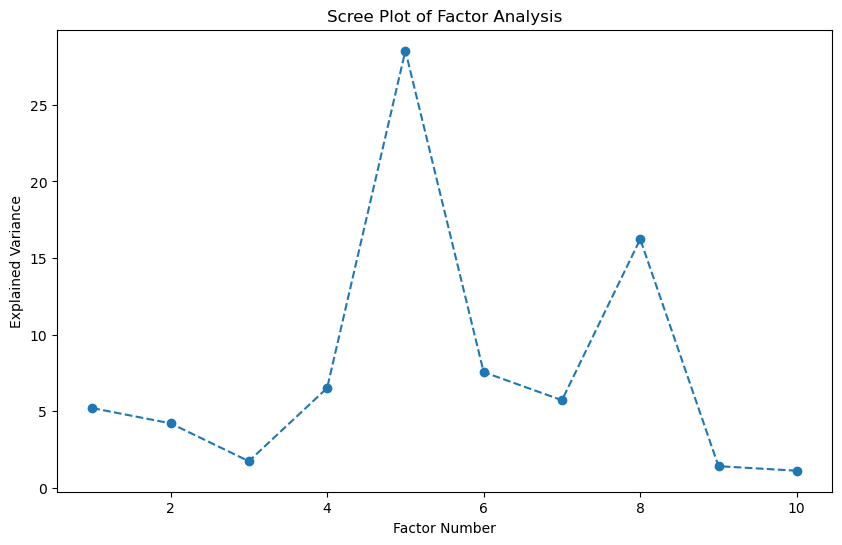

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_factors + 1), explained_variance, marker="o", linestyle="--")
plt.xlabel("Factor Number")
plt.ylabel("Explained Variance")
plt.title("Scree Plot of Factor Analysis")
plt.show()


In [19]:
feature_names = X.columns  # Extract feature names from the dataset (X)

for i in range(10):
    # Extract the loadings for the 5th factor
    factor_loadings = fa.components_[i]
    
    # Create a DataFrame to display factor loadings against feature names
    factor_df = pd.DataFrame({
        'Feature': feature_names,
        'Factor Loading': factor_loadings
    })
    # Sort the factor loadings in descending order to identify the most significant features for this factor
    factor_df_sorted = factor_df.sort_values(by='Factor Loading', ascending=False)
    
    # Print the sorted factor loadings
    print(f"\n Factor {i+1} loadings\n{factor_df_sorted.head(10)}")


 Factor 1 loadings
         Feature  Factor Loading
32    BsmtFinSF1        0.985595
10  Neighborhood        0.767250
44  BsmtFullBath        0.658269
36   TotalBsmtSF        0.620332
52    Fireplaces        0.288528
15   OverallQual        0.281865
24    MasVnrArea        0.278407
17     YearBuilt        0.274005
56    GarageCars        0.257036
2    LotFrontage        0.248679

 Factor 2 loadings
         Feature  Factor Loading
35     BsmtUnfSF        0.897022
36   TotalBsmtSF        0.774611
10  Neighborhood        0.495996
15   OverallQual        0.475011
31  BsmtFinType1        0.420734
22   Exterior2nd        0.392385
43     GrLivArea        0.387786
21   Exterior1st        0.371305
56    GarageCars        0.359614
46      FullBath        0.357753

 Factor 3 loadings
         Feature  Factor Loading
34    BsmtFinSF2        0.992503
10  Neighborhood        0.228541
38     HeatingQC        0.137720
36   TotalBsmtSF        0.123150
3        LotArea        0.102783
44  BsmtFullBath

In [20]:
# Assuming df_cleaned is your dataframe and you have already fitted the FactorAnalysis model (fa)
feature_names = X.columns  # Extract feature names from the dataset (X)

# Extract the loadings for the 5th factor
factor_5_loadings = fa.components_[4]

# Create a DataFrame to display factor loadings against feature names
factor_5_df = pd.DataFrame({
    'Feature': feature_names,
    'Factor 5 Loading': factor_5_loadings
})

# Sort the factor loadings in descending order to identify the most significant features for this factor
factor_5_df_sorted = factor_5_df.sort_values(by='Factor 5 Loading', ascending=False)

# Print the sorted factor loadings
print(factor_5_df_sorted.head(10))


          Feature  Factor 5 Loading
10   Neighborhood          5.210752
43      GrLivArea          0.298910
41       2ndFlrSF          0.282978
0      MSSubClass          0.263665
14     HouseStyle          0.243677
49   KitchenAbvGr          0.217977
54     GarageType          0.195528
48   BedroomAbvGr          0.191528
62  EnclosedPorch          0.162754
30   BsmtExposure          0.156954


### Lasso Regression

In [46]:
# Feature Selection Using LASSO (L1 Regularization)
# LASSO (Least Absolute Shrinkage and Selection Operator) sets some coefficients to zero, effectively selecting only the most important features.

X = df_final.drop(["SalePrice","log(SalePrice)"], axis=1)
y = df_final['SalePrice']

X_scaled = X

# Apply LASSO with Cross-Validation
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_scaled, y)

# Select non-zero coefficients
non_zero_mask = lasso.coef_ != 0
selected_features = np.array(X.columns)[non_zero_mask]
coefficients = lasso.coef_[non_zero_mask]

# Sort features by absolute coefficient value (highest to lowest)
sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Sort descending
sorted_features = selected_features[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Print sorted features with coefficients
print(f"Total number of features in dataset :{len(X.columns)}\nTotal number of features with non-zero coefficients: {len(selected_features)}")

# Print sorted features with coefficients
print("LASSO Selected Features (Sorted by Importance):")
for feature, coef in zip(sorted_features, sorted_coefficients):
    print(f"{feature}: {coef:.4f}")



Total number of features in dataset :72
Total number of features with non-zero coefficients: 40
LASSO Selected Features (Sorted by Importance):
GrLivArea: 25206.3593
OverallQual: 17747.4433
BsmtQual: -9408.3189
KitchenQual: -8621.2918
GarageCars: 7566.0838
ExterQual: -7514.2182
MSSubClass: -5413.9075
YearBuilt: 5006.2481
MasVnrArea: 4158.1415
Fireplaces: 3653.3543
OverallCond: 3552.0635
BsmtExposure: -3482.2843
LotArea: 3410.6272
BsmtFinSF1: 3161.9664
BsmtFullBath: 2781.0042
RoofMatl: 2621.4269
Functional: 2580.6907
SaleCondition: 2062.2443
WoodDeckSF: 1872.8725
ScreenPorch: 1786.8754
TotalBsmtSF: 1627.3663
BsmtFinType1: -1210.7906
BldgType: -1160.5472
HeatingQC: -1130.1604
YearRemodAdd: 1129.8087
RoofStyle: 1116.1501
KitchenAbvGr: -866.6038
LotShape: -842.8875
FireplaceQu: -806.0025
FullBath: 798.6580
LandContour: 726.8848
HouseStyle: -689.3202
Exterior1st: -536.9813
LotFrontage: -503.1490
Neighborhood: 368.5646
GarageType: -172.9849
LowQualFinSF: -163.8336
SaleType: -98.9254
BsmtCond

In [47]:
# Select the top 10 features
top_n = 10
top_features = sorted_features[:top_n]
top_coefficients = sorted_coefficients[:top_n]

# Print the top 10 features with their coefficients
print("Top 10 LASSO Selected Features (Sorted):")
for feature, coef in zip(top_features, top_coefficients):
    print(f"{feature}: {coef:.4f}")

Top 10 LASSO Selected Features (Sorted):
GrLivArea: 25206.3593
OverallQual: 17747.4433
BsmtQual: -9408.3189
KitchenQual: -8621.2918
GarageCars: 7566.0838
ExterQual: -7514.2182
MSSubClass: -5413.9075
YearBuilt: 5006.2481
MasVnrArea: 4158.1415
Fireplaces: 3653.3543


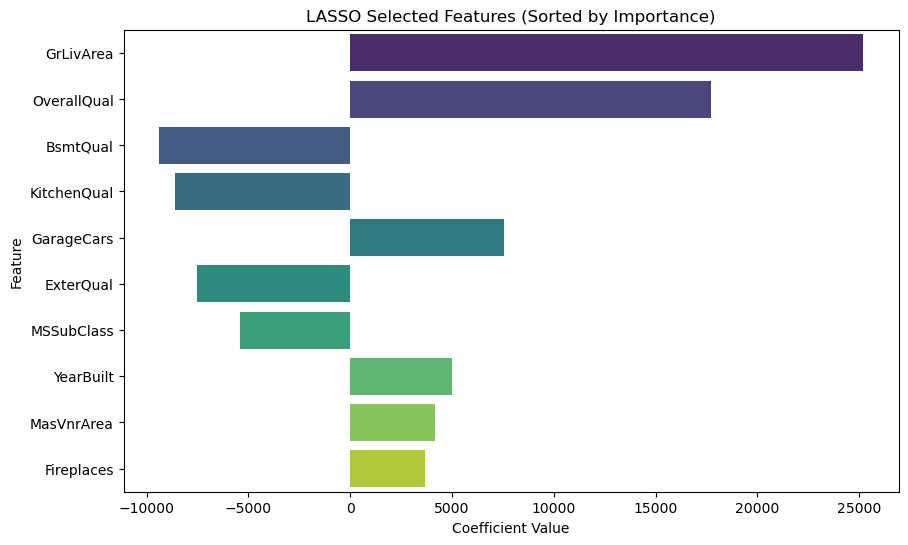

In [23]:
# Convert to DataFrame for Seaborn compatibility
lasso_df = pd.DataFrame({"Feature": sorted_features[:10], "Coefficient": sorted_coefficients[:10]})

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", hue="Feature", data=lasso_df, palette="viridis", legend=False)
plt.title("LASSO Selected Features (Sorted by Importance)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

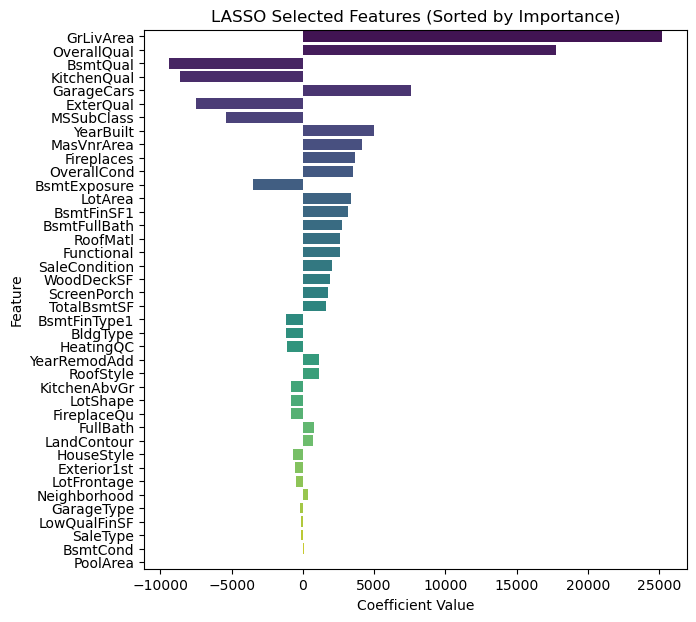

In [24]:
# Convert to DataFrame for Seaborn compatibility
lasso_df = pd.DataFrame({"Feature": sorted_features, "Coefficient": sorted_coefficients})

# Plot feature importance
plt.figure(figsize=(7, 7))
sns.barplot(x="Coefficient", y="Feature", hue="Feature", data=lasso_df, palette="viridis", legend=False)
plt.title("LASSO Selected Features (Sorted by Importance)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [ ]:
print(selected_features)
print(len(selected_features))

# Research Question 1 : Can we develop a machine learning model to accurately predict house prices using the available features? How does the model performance compare across different regression techniques?

## Regression and tree-based models

### Target variable - `SalePrice` + All features

In [26]:
df_model = df_final.copy()

# Separate target variable
X = df_model.drop(["SalePrice", "log(SalePrice)"], axis=1)
y = df_model["SalePrice"]

# Define models and hyperparameter grids
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  # No hyperparameters for Linear Regression
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [5, 10, 15, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 10]
        }
    }
}

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models and evaluate using GridSearchCV
results_1 = []
for name, config in models.items():
    print(f"Training {name}...")
    print(f"..............................................................")

    if config["params"]:  # If there are hyperparameters to tune
        grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_rmse = -grid_search.best_score_  # Convert negative RMSE to positive

        #GridSearchCV in scikit-learn requires all scoring metrics to follow a maximization approach (higher values are better). However, RMSE is a minimization metric (lower RMSE is better).

        print(f"Best parameters for {name}: {best_params}")
        
    else:  # For Linear Regression (no hyperparameters)
        best_model = config["model"].fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        best_rmse = mean_squared_error(y_test, y_pred, squared=False)
        best_params = "N/A"

    # Evaluate on test set
    y_pred_test = best_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    results_1.append({
        "Model": name,
        "Best Params": best_params,
        "CV RMSE": best_rmse,
        "Test RMSE": test_rmse
    })

    print(f"Test RMSE for {name}: {test_rmse}")
    print(f"CV RMSE for {name}: {best_rmse}\n")

# Convert results to DataFrame
results_1_df = pd.DataFrame(results_1).sort_values(by="Test RMSE")
print(results_1_df)

Training Linear Regression...
..............................................................
Test RMSE for Linear Regression: 36224.99250020017
CV RMSE for Linear Regression: 36224.99250020017

Training Decision Tree...
..............................................................
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 10}
Test RMSE for Decision Tree: 39210.88375448596
CV RMSE for Decision Tree: 40338.6242294063

Training Random Forest...
..............................................................
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Test RMSE for Random Forest: 28235.911987214204
CV RMSE for Random Forest: 29985.512327795954

Training Gradient Boosting...
..............................................................
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Test RMSE for Gradient Boosting: 26717.07785717426
CV RMSE for Gradie

### Target variable - `SalePrice` + LASSO selected features

In [ ]:
df_final[selected_features]

In [27]:
df_model = df_final.copy()

# Separate target variable
X = df_model[selected_features]
y = df_model["SalePrice"]

# Define models and hyperparameter grids
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  # No hyperparameters for Linear Regression
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [5, 10, 15, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 10]
        }
    }
}

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models and evaluate using GridSearchCV
results_2 = []
for name, config in models.items():
    print(f"Training {name}...")
    print(f"..............................................................")

    if config["params"]:  # If there are hyperparameters to tune
        grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_rmse = -grid_search.best_score_  # Convert negative RMSE to positive

        #GridSearchCV in scikit-learn requires all scoring metrics to follow a maximization approach (higher values are better). However, RMSE is a minimization metric (lower RMSE is better).

        print(f"Best parameters for {name}: {best_params}")
        
    else:  # For Linear Regression (no hyperparameters)
        best_model = config["model"].fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        best_rmse = mean_squared_error(y_test, y_pred, squared=False)
        best_params = "N/A"

    # Evaluate on test set
    y_pred_test = best_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    results_2.append({
        "Model": name,
        "Best Params": best_params,
        "CV RMSE": best_rmse,
        "Test RMSE": test_rmse
    })

    print(f"Test RMSE for {name}: {test_rmse}")
    print(f"CV RMSE for {name}: {best_rmse}\n")

# Convert results to DataFrame
results_2_df = pd.DataFrame(results_2).sort_values(by="Test RMSE")
print(results_2_df)

Training Linear Regression...
..............................................................
Test RMSE for Linear Regression: 33947.7649236258
CV RMSE for Linear Regression: 33947.7649236258

Training Decision Tree...
..............................................................
Best parameters for Decision Tree: {'max_depth': 15, 'min_samples_split': 2}
Test RMSE for Decision Tree: 43781.77227669186
CV RMSE for Decision Tree: 41062.93680629408

Training Random Forest...
..............................................................
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Test RMSE for Random Forest: 30454.435118200832
CV RMSE for Random Forest: 30840.316905619966

Training Gradient Boosting...
..............................................................
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Test RMSE for Gradient Boosting: 28868.011298428508
CV RMSE for Gradient

### Target variable - `log(SalePrice)` + All features

In [28]:
df_model = df_final.copy()

# Separate target variable
X = df_model.drop(["SalePrice", "log(SalePrice)"], axis=1)
y = df_model["log(SalePrice)"]

# Define models and hyperparameter grids
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  # No hyperparameters for Linear Regression
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [5, 10, 15, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 10]
        }
    }
}

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models and evaluate using GridSearchCV
results_3 = []
for name, config in models.items():
    print(f"Training {name}...")
    print(f"..............................................................")

    if config["params"]:  # If there are hyperparameters to tune
        grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_rmse = -grid_search.best_score_  # Convert negative RMSE to positive

        print(f"Best parameters for {name}: {best_params}")
        
    else:  # For Linear Regression (no hyperparameters)
        best_model = config["model"].fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        best_rmse = mean_squared_error(y_test, y_pred, squared=False)
        best_params = "N/A"

    # Evaluate on test set
    y_pred_test = best_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    results_3.append({
        "Model": name,
        "Best Params": best_params,
        "CV RMSE": best_rmse,
        "Test RMSE": test_rmse
    })

    print(f"Test RMSE for {name}: {test_rmse}")
    print(f"CV RMSE for {name}: {best_rmse}\n")

# Convert results to DataFrame
results_3_df = pd.DataFrame(results_3).sort_values(by="Test RMSE")
print(results_3_df)

Training Linear Regression...
..............................................................
Test RMSE for Linear Regression: 0.15845218856301643
CV RMSE for Linear Regression: 0.15845218856301643

Training Decision Tree...
..............................................................
Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
Test RMSE for Decision Tree: 0.1948282708117082
CV RMSE for Decision Tree: 0.19895292966765532

Training Random Forest...
..............................................................
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Test RMSE for Random Forest: 0.14338620629263976
CV RMSE for Random Forest: 0.14280998517777904

Training Gradient Boosting...
..............................................................
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Test RMSE for Gradient Boosting: 0.1390016323333642
CV RMSE for

### Target variable - `log(SalePrice)` + LASSO selected features

In [29]:
df_model = df_final.copy()

# Separate target variable
X = df_model[selected_features]
y = df_model["log(SalePrice)"]

# Define models and hyperparameter grids
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  # No hyperparameters for Linear Regression
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [5, 10, 15, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 10]
        }
    }
}

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models and evaluate using GridSearchCV
results_4 = []
for name, config in models.items():
    print(f"Training {name}...")
    print(f"..............................................................")

    if config["params"]:  # If there are hyperparameters to tune
        grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_rmse = -grid_search.best_score_  # Convert negative RMSE to positive

        print(f"Best parameters for {name}: {best_params}")
        
    else:  # For Linear Regression (no hyperparameters)
        best_model = config["model"].fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        best_rmse = mean_squared_error(y_test, y_pred, squared=False)
        best_params = "N/A"

    # Evaluate on test set
    y_pred_test = best_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    results_4.append({
        "Model": name,
        "Best Params": best_params,
        "CV RMSE": best_rmse,
        "Test RMSE": test_rmse
    })

    print(f"Test RMSE for {name}: {test_rmse}")
    print(f"CV RMSE for {name}: {best_rmse}\n")

# Convert results to DataFrame
results_4_df = pd.DataFrame(results_4).sort_values(by="Test RMSE")
print(results_4_df)

Training Linear Regression...
..............................................................
Test RMSE for Linear Regression: 0.15335908118661465
CV RMSE for Linear Regression: 0.15335908118661465

Training Decision Tree...
..............................................................
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
Test RMSE for Decision Tree: 0.1949781343709878
CV RMSE for Decision Tree: 0.19983147614720703

Training Random Forest...
..............................................................
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Test RMSE for Random Forest: 0.14670432990002943
CV RMSE for Random Forest: 0.14362859337836137

Training Gradient Boosting...
..............................................................
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Test RMSE for Gradient Boosting: 0.1374384731806182
CV RMSE f

## GLM

In [30]:
# Convert categorical variables to dummy variables (one-hot encoding)
df_glm = df_final.copy()
df_glm = pd.get_dummies(df_glm, drop_first=True)

# Convert dummy columns that are binary to int (they should already be binary, but this ensures they are integers)
df_glm = df_glm.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

df_glm.info()
df_glm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 236 entries, MSSubClass to SaleCondition_5
dtypes: float64(33), int32(202), int64(1)
memory usage: 1.5 MB


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0,0,0,0,1,0,0,0,1,0
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,0,0,0,0,1,0,0,0,1,0
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0,0,0,0,1,0,0,0,1,0
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0,0,0,0,1,0,0,0,0,0
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0,0,0,0,1,0,0,0,1,0


### Target variable - `SalePrice`

In [31]:
# Add intercept
df_glm["Intercept"] = 1

df_glm.info()
# Define independent (X) and dependent (y) variables
X = df_glm.drop(['SalePrice', 'log(SalePrice)'], axis = 1)
y = df_glm["SalePrice"]

# Fit a Gamma GLM with a log link function
model = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
result = model.fit()

# Print summary
print(result.summary())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 237 entries, MSSubClass to Intercept
dtypes: float64(33), int32(202), int64(2)
memory usage: 1.5 MB
                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1227
Model Family:                   Gamma   Df Model:                          232
Link Function:                    log   Scale:                        0.010042
Method:                          IRLS   Log-Likelihood:                -16187.
Date:                Fri, 21 Mar 2025   Deviance:                       13.016
Time:                        22:20:56   Pearson chi2:                     12.3
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef 

### Target variable - log(SalePrice)

In [32]:
import statsmodels.api as sm

# Add intercept
df_glm["Intercept"] = 1

# Define independent (X) and dependent (y) variables
X = df_glm.drop(['SalePrice', 'log(SalePrice)'], axis=1)  
y = df_glm["log(SalePrice)"]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Gaussian GLM with a log link function on the training data
model = sm.GLM(y_train, X_train, family=sm.families.Gaussian(sm.families.links.log()))
result = model.fit()

# Print model summary
print(result.summary())

# Predict on the test set
y_pred = result.predict(X_test)

# Convert log predictions back to original scale
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:         log(SalePrice)   No. Observations:                 1168
Model:                            GLM   Df Residuals:                      937
Model Family:                Gaussian   Df Model:                          230
Link Function:                    log   Scale:                        0.011015
Method:                          IRLS   Log-Likelihood:                 1091.2
Date:                Fri, 21 Mar 2025   Deviance:                       10.321
Time:                        22:21:05   Pearson chi2:                     10.3
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
MSSubClass         -0.0022      0.002     

# Research Question 2 : Which features have the highest predictive power? What feature engineering techniques enhance model accuracy?

In [ ]:
results_3

In [33]:
# Extract the best parameters for Gradient Boosting
gb_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

feature_names = X_train.columns 

# Train Gradient Boosting with best params
gb_model = GradientBoostingRegressor(**gb_params, random_state=42)
gb_model.fit(X_train, y_train)

# Extract feature importances
feature_importance = gb_model.feature_importances_

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
})

# Sort features by importance (descending order)
top_features = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display top 10 most important features
print(top_features.head(10))

            Feature  Importance
3       OverallQual    0.448005
14        GrLivArea    0.192780
22       GarageCars    0.062523
11      TotalBsmtSF    0.050542
5         YearBuilt    0.043672
6      YearRemodAdd    0.027321
8        BsmtFinSF1    0.025180
2           LotArea    0.023072
183    CentralAir_1    0.020278
207  GarageFinish_2    0.016508


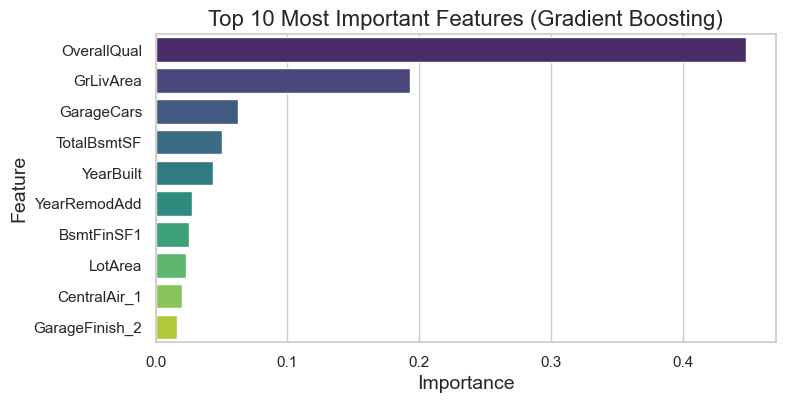

In [34]:
# Set the plot style
sns.set(style="whitegrid")

# Create a bar plot for the top 10 most important features
plt.figure(figsize=(8, 4))
sns.barplot(x="Importance", y="Feature", data=top_features.head(10), palette="viridis")

# Set plot labels and title
plt.title("Top 10 Most Important Features (Gradient Boosting)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Show the plot
plt.show()

# Research Question 3 : What is the statistical distribution of house prices, and what factors influence this distribution?

## Statistical distribution of house prices

In [35]:
prices = df_final["SalePrice"].dropna()
prices.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Histograms and distribution curves

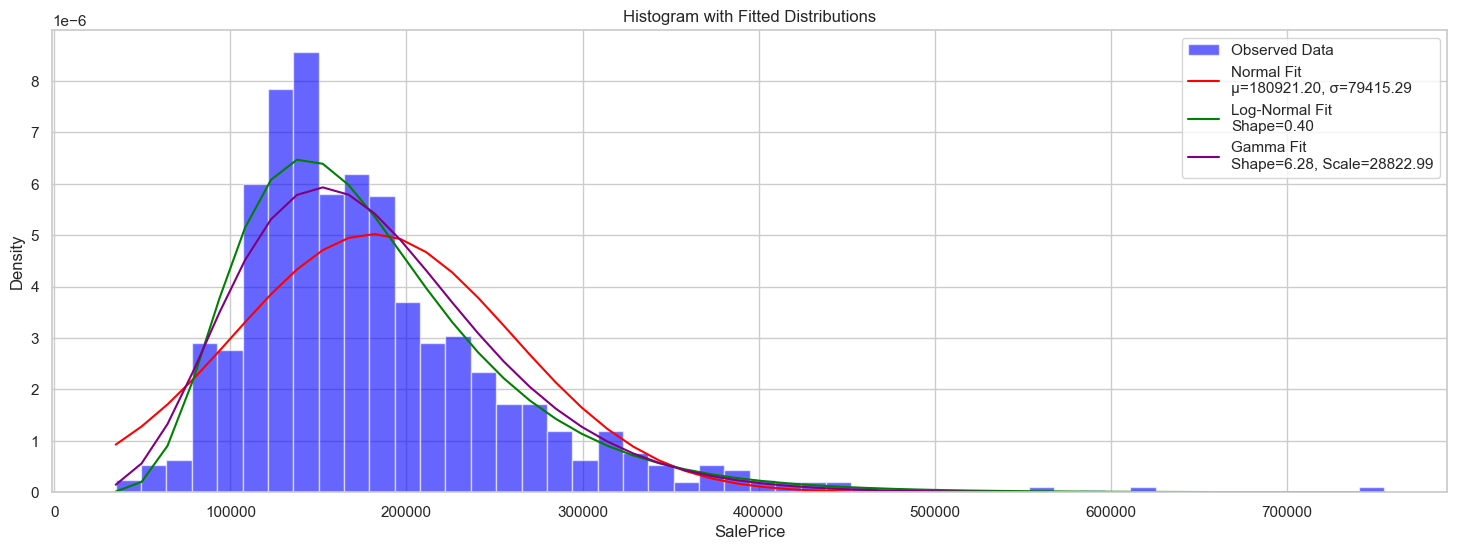

In [36]:
# Apply seaborn styling
sns.set_style("whitegrid")

# Prepare data
x = np.linspace(prices.min(), prices.max())

# Create a histogram of observed data
plt.figure(figsize=(18, 6))
plt.hist(prices, bins=50, density=True, alpha=0.6, color='blue', label="Observed Data")

# Fit and plot Normal distribution
mu, sigma = stats.norm.fit(prices)
pdf_norm = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf_norm, label=f'Normal Fit\nμ={mu:.2f}, σ={sigma:.2f}', color='red')

# Fit and plot Log-Normal distribution
shape, loc, scale = stats.lognorm.fit(prices)
pdf_lognorm = stats.lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf_lognorm, label=f'Log-Normal Fit\nShape={shape:.2f}', color='green')

# Fit and plot Gamma distribution (forcing loc=0)
shape_g, loc_g, scale_g = stats.gamma.fit(prices, floc=0)
pdf_gamma = stats.gamma.pdf(x, shape_g, loc_g, scale_g)
plt.plot(x, pdf_gamma, label=f'Gamma Fit\nShape={shape_g:.2f}, Scale={scale_g:.2f}', color='purple')

# Labels and legend
plt.title("Histogram with Fitted Distributions")
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.legend()

# Show plot
plt.show()

### Q-Q Plot (Visual Method for Skewed Distributions)

If the data follows a specific distribution, the points should be aligned along the reference line.

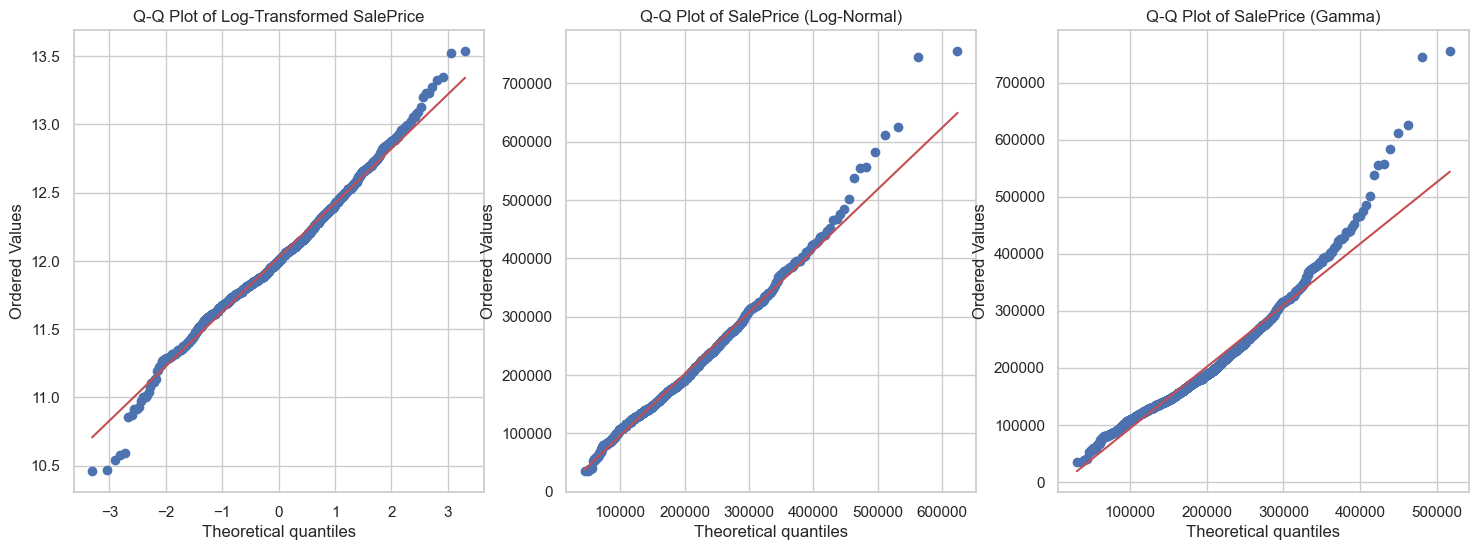

In [37]:
# Fit Log-Normal and Gamma Distributions
shape, loc, scale = stats.lognorm.fit(df_final["SalePrice"])
shape_g, loc_g, scale_g = stats.gamma.fit(df_final["SalePrice"], floc=0)  # Fix loc=0 for gamma

# Create Subplots for Q-Q Plots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Normal Q-Q plot (log-transformed)
stats.probplot(np.log(df_final["SalePrice"]), dist="norm", plot=ax[0])
ax[0].set_title("Q-Q Plot of Log-Transformed SalePrice")

# Log-Normal Q-Q plot
stats.probplot(df_final["SalePrice"], dist="lognorm", sparams=(shape, loc, scale), plot=ax[1])
ax[1].set_title("Q-Q Plot of SalePrice (Log-Normal)")

# Gamma Q-Q plot
stats.probplot(df_final["SalePrice"], dist="gamma", sparams=(shape_g, loc_g, scale_g), plot=ax[2])
ax[2].set_title("Q-Q Plot of SalePrice (Gamma)")

plt.show()

### Distribution Selection Based on AIC/BIC (Best-Fit Model)

To determine which distribution fits best, we compare Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).

Lower AIC/BIC = Better fit to data.
Compares multiple distributions: log-normal, gamma

In [38]:
from scipy.stats import norm, lognorm, gamma, expon

def compute_aic_bic(distribution, data):
    params = distribution.fit(data)
    log_likelihood = np.sum(distribution.logpdf(data, *params))
    k = len(params)  # Number of parameters
    n = len(data)
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + k * np.log(n)
    return aic, bic

data = df_final["SalePrice"].dropna()

# Fit different distributions
aic_norm, bic_norm = compute_aic_bic(norm, data)
aic_lognorm, bic_lognorm = compute_aic_bic(lognorm, data)
aic_gamma, bic_gamma = compute_aic_bic(gamma, data)

print(f"AIC Log-Normal: {aic_lognorm:.2f}, BIC Log-Normal: {bic_lognorm:.2f}")
print(f"AIC Normal: {aic_norm:.2f}, BIC Normal: {bic_norm:.2f}")
print(f"AIC Gamma: {aic_gamma:.2f}, BIC Gamma: {bic_gamma:.2f}")


best_aic = min(aic_lognorm, aic_norm, aic_gamma)
if best_aic == aic_lognorm:
    print("Log-Normal fits best based on AIC.")
elif best_aic == aic_norm:
    print("Normal fits best based on AIC.")
elif best_aic == aic_gamma:
    print("Gamma fits best based on AIC.")

best_bic = min(bic_lognorm, bic_norm, bic_gamma)
if best_bic == bic_lognorm:
    print("Log-Normal fits best based on BIC.")
elif best_bic == bic_norm:
    print("Normal fits best based on BIC.")
elif best_bic == bic_gamma:
    print("Gamma fits best based on BIC.")

AIC Log-Normal: 36578.96, BIC Log-Normal: 36594.81
AIC Normal: 37092.04, BIC Normal: 37102.62
AIC Gamma: 42812.92, BIC Gamma: 42828.78
Log-Normal fits best based on AIC.
Log-Normal fits best based on BIC.


### Shapiro-Wilk Test
Tests whether the log-transformed data is normally distributed.
If the log-transformed data is normal, the original data may be log-normal.

In [39]:
from scipy.stats import shapiro
import numpy as np

log_prices = np.log(df_final["SalePrice"].dropna())

stat, p = shapiro(log_prices)
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p:.4f}")

if p > 0.05:
    print("Fail to reject H₀: Log-transformed SalePrice is normally distributed (suggests log-normal).")
else:
    print("Reject H₀: Log-transformed SalePrice is NOT normally distributed (unlikely to be log-normal).")


Shapiro-Wilk Test Statistic: 0.9912, p-value: 0.0000
Reject H₀: Log-transformed SalePrice is NOT normally distributed (unlikely to be log-normal).


### Anderson-Darling Test
More powerful than Shapiro-Wilk.
Checks if log-transformed data is normal.

In [40]:
from scipy.stats import anderson

result = anderson(log_prices, dist='norm')
print("Anderson-Darling Test Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)

if result.statistic < result.critical_values[2]:  # Check at 5% significance level
    print("Fail to reject H₀: Log-transformed SalePrice is normally distributed.")
else:
    print("Reject H₀: Log-transformed SalePrice is NOT normally distributed.")


Anderson-Darling Test Statistic: 3.5387544749892186
Critical Values: [0.574 0.654 0.785 0.916 1.089]
Significance Levels: [15.  10.   5.   2.5  1. ]
Reject H₀: Log-transformed SalePrice is NOT normally distributed.


# Research Question 4 : Are there non-linear relationships between house prices and key features? Can advanced modeling techniques capture these relationships more effectively than linear models?

## Polynomial Regression

In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      1460 non-null   float64
 1   MSZoning        1460 non-null   object 
 2   LotFrontage     1460 non-null   float64
 3   LotArea         1460 non-null   float64
 4   Street          1460 non-null   object 
 5   LotShape        1460 non-null   object 
 6   LandContour     1460 non-null   object 
 7   Utilities       1460 non-null   object 
 8   LotConfig       1460 non-null   object 
 9   LandSlope       1460 non-null   object 
 10  Neighborhood    1460 non-null   object 
 11  Condition1      1460 non-null   object 
 12  Condition2      1460 non-null   object 
 13  BldgType        1460 non-null   object 
 14  HouseStyle      1460 non-null   object 
 15  OverallQual     1460 non-null   float64
 16  OverallCond     1460 non-null   float64
 17  YearBuilt       1460 non-null   f

In [48]:
# Polynomial Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# state x and y variables
X = df_final.drop(["SalePrice", "log(SalePrice)"], axis=1)
y = df_final["log(SalePrice)"]

# select top 10 lasso features
X_sample = X[top_features]  

# train/test
X_train, X_test, y_train, y_test = train_test_split(X_sample, y, test_size=0.2, random_state=42)

# pipeline
poly_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression())
])

# model
poly_model.fit(X_train, y_train)

# Predictions
y_pred = poly_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5


print(f"Polynomial Regression (Degree 2)")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


Polynomial Regression (Degree 2)
R²: 0.8393
RMSE: 0.1732


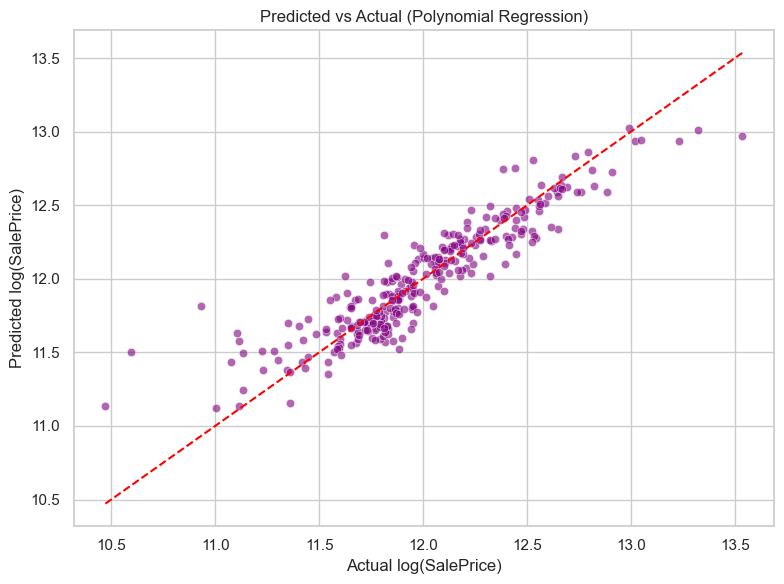

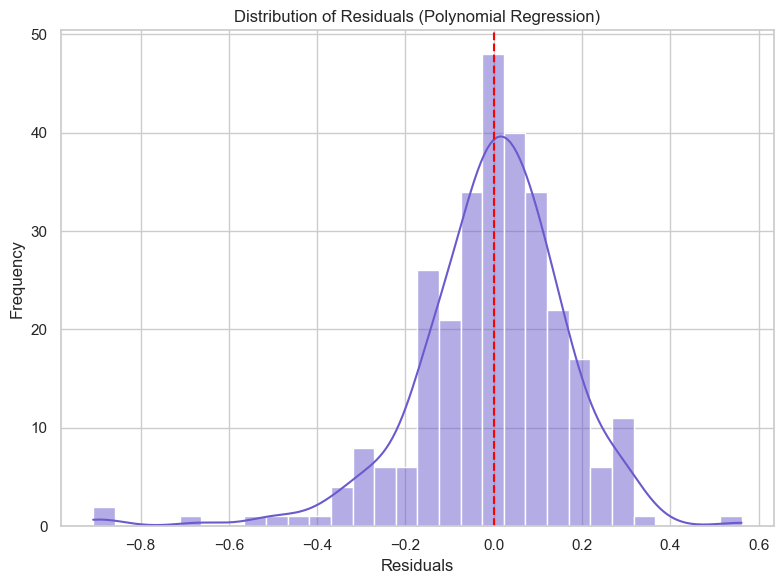

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual log(SalePrice)")
plt.ylabel("Predicted log(SalePrice)")
plt.title("Predicted vs Actual (Polynomial Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='slateblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Polynomial Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Research Question 5 : How do temporal factors influence house prices? 

In [50]:
# Load dataset
df_5 = pd.read_csv("train.csv", parse_dates = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'])

df_5 = df_5.drop('Id', axis = 1) # Drop ID column
df_5['log(SalePrice)'] = np.log1p(df_5["SalePrice"]) # Log transformation of target variable = 'SalePrice'
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   MSSubClass      1460 non-null   int64         
 1   MSZoning        1460 non-null   object        
 2   LotFrontage     1201 non-null   float64       
 3   LotArea         1460 non-null   int64         
 4   Street          1460 non-null   object        
 5   Alley           91 non-null     object        
 6   LotShape        1460 non-null   object        
 7   LandContour     1460 non-null   object        
 8   Utilities       1460 non-null   object        
 9   LotConfig       1460 non-null   object        
 10  LandSlope       1460 non-null   object        
 11  Neighborhood    1460 non-null   object        
 12  Condition1      1460 non-null   object        
 13  Condition2      1460 non-null   object        
 14  BldgType        1460 non-null   object        
 15  Hous

In [51]:
## delete columns with more than 90% missing values
threshold = 0.9  
missing_percent = df_5.isnull().mean()
df_5 = df_5.loc[:, missing_percent < threshold]
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   MSSubClass      1460 non-null   int64         
 1   MSZoning        1460 non-null   object        
 2   LotFrontage     1201 non-null   float64       
 3   LotArea         1460 non-null   int64         
 4   Street          1460 non-null   object        
 5   LotShape        1460 non-null   object        
 6   LandContour     1460 non-null   object        
 7   Utilities       1460 non-null   object        
 8   LotConfig       1460 non-null   object        
 9   LandSlope       1460 non-null   object        
 10  Neighborhood    1460 non-null   object        
 11  Condition1      1460 non-null   object        
 12  Condition2      1460 non-null   object        
 13  BldgType        1460 non-null   object        
 14  HouseStyle      1460 non-null   object        
 15  Over

In [52]:
df_plot = df_5.copy()
df_plot['YearBuilt'] = df_plot['YearBuilt'].dt.year
df_plot['YearRemodAdd'] = df_plot['YearRemodAdd'].dt.year

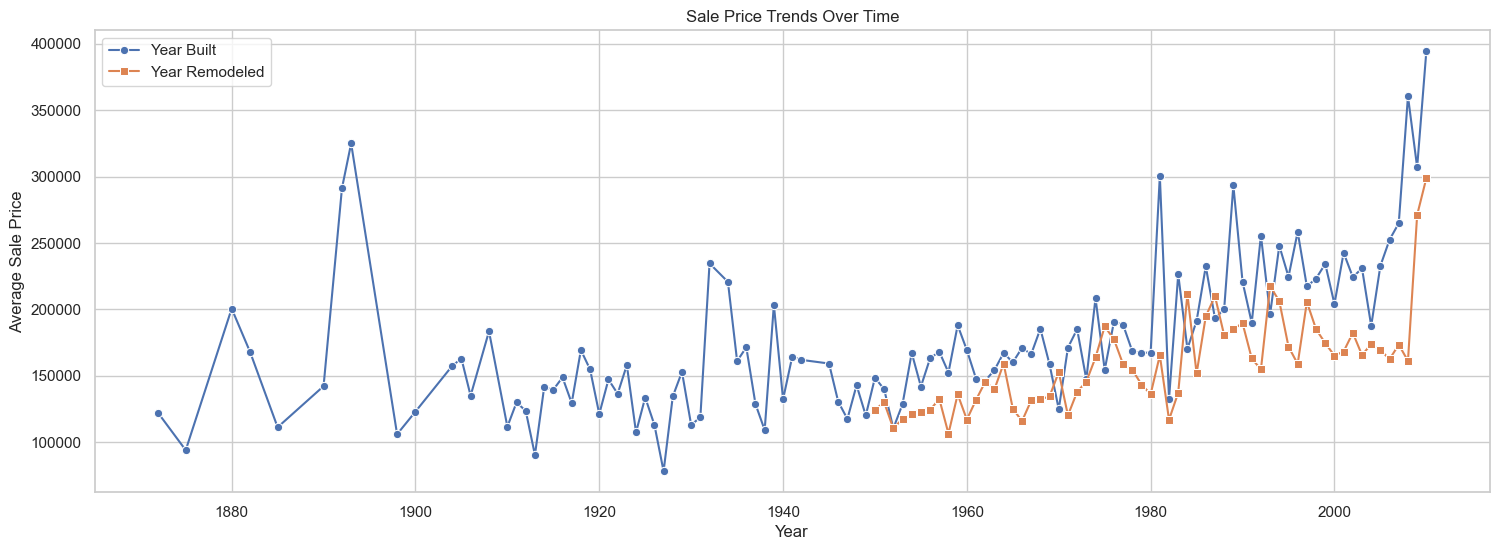

In [53]:
# Compute the average SalePrice per year for each temporal variable
df_avg = df_plot.groupby(['YearBuilt', 'YearRemodAdd'])['SalePrice'].mean().reset_index()

plt.figure(figsize=(18, 6))

# Plot lines for each temporal feature without confidence interval (shading)
sns.lineplot(x='YearBuilt', y='SalePrice', data=df_avg, label='Year Built', marker='o', ci=None)
sns.lineplot(x='YearRemodAdd', y='SalePrice', data=df_avg, label='Year Remodeled', marker='s', ci=None)
#sns.lineplot(x='GarageYrBlt', y='SalePrice', data=df_avg, label='Garage Year Built', marker='D', ci=None)
#sns.lineplot(x='YrSold', y='SalePrice', data=df_avg, label='Year Sold', marker='^', ci=None)

# Labels and legend
plt.title('Sale Price Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sale Price')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

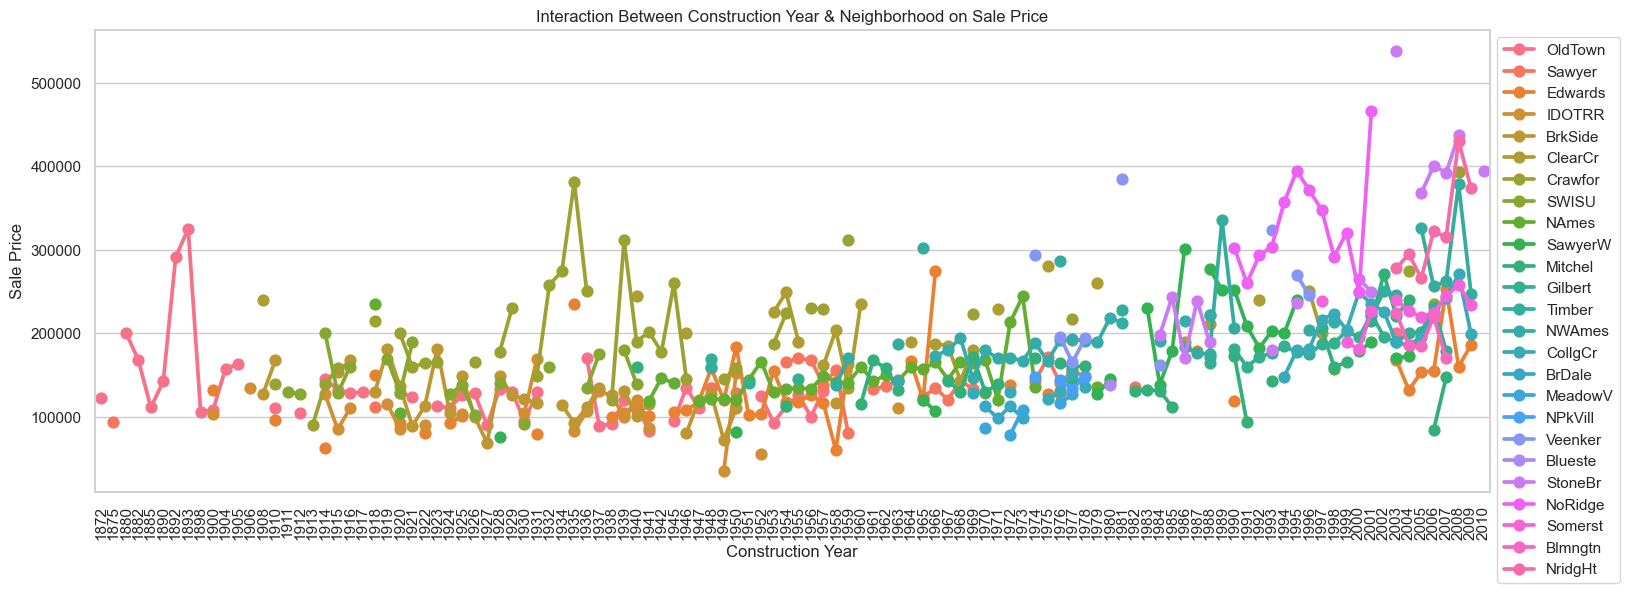

In [54]:
# Compute the average SalePrice per year for each temporal variable
df_avg = df_plot.groupby(['YearBuilt', 'Neighborhood'])['SalePrice'].mean().reset_index()
plt.figure(figsize=(18, 6))
sns.pointplot(x='YearBuilt', y='SalePrice', hue='Neighborhood', data=df_avg, ci=None)
#year_ticks = np.arange(df_avg['YearBuilt'].min(), df_avg['YearBuilt'].max() + 1, 10)
#plt.xticks(year_ticks, rotation=90)  # Rotate labels for better readability

plt.xticks(rotation=90)
plt.title('Interaction Between Construction Year & Neighborhood on Sale Price')
plt.xlabel('Construction Year')
plt.ylabel('Sale Price')
# Adjust legend position
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


In [55]:
# MIXED Effects model

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

df_mixed = df_plot.copy()
df_mixed = df_mixed.dropna(subset=['YearBuilt', 'Neighborhood', 'log(SalePrice)'])

# model
model = mixedlm("Q('log(SalePrice)') ~ YearBuilt", 
                data=df_mixed, 
                groups=df_mixed["Neighborhood"])

result = model.fit()


print(result.summary())


              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('log(SalePrice)')
No. Observations: 1460    Method:             REML               
No. Groups:       25      Scale:              0.0657             
Min. group size:  2       Log-Likelihood:     -140.3464          
Max. group size:  225     Converged:          Yes                
Mean group size:  58.4                                           
--------------------------------------------------------------------
             Coef.    Std.Err.      z      P>|z|    [0.025    0.975]
--------------------------------------------------------------------
Intercept    2.920       0.924    3.160    0.002     1.109     4.731
YearBuilt    0.005       0.000    9.880    0.000     0.004     0.006
Group Var    0.076       0.091                                      



In [56]:
# fixed effects: year built and year remodeled

import statsmodels.api as sm
from statsmodels.formula.api import ols

df_fixed = df_mixed.copy()
df_fixed = df_fixed.dropna(subset=['YearBuilt', 'YearRemodAdd', 'log(SalePrice)'])

# model
fixed_model = ols("Q('log(SalePrice)') ~ YearBuilt + YearRemodAdd", data=df_fixed).fit()

print(fixed_model.summary())


                             OLS Regression Results                            
Dep. Variable:     Q('log(SalePrice)')   R-squared:                       0.417
Model:                             OLS   Adj. R-squared:                  0.416
Method:                  Least Squares   F-statistic:                     521.6
Date:                 Fri, 21 Mar 2025   Prob (F-statistic):          1.43e-171
Time:                         22:23:45   Log-Likelihood:                -337.16
No. Observations:                 1460   AIC:                             680.3
Df Residuals:                     1457   BIC:                             696.2
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.9770      0.772    